# Segmentación de Tumores Cerebrales usando Redes Convolucionales

Este texto introduce un proyecto que busca mejorar la segmentación de tumores cerebrales en imágenes de resonancia magnética (MRI) utilizando inteligencia artificial y modelos de aprendizaje profundo. Con este proceso de segmentación ayuda a la planificación del tratamiento  el pronósitico de un paciente, por lo que creando un modelo de aprendizaje profundo se podrán clasificar nuevas resonancias magnéticas para detectar si en estas se presenta algún tumor o no.

El conjunto de datos aportado incluye diferentes secuencias de MRI, según la configuación elegida, entre las que se encuentran:

* T1-weighted (T1): Captura la anatomía del cerebro, así como diferenciar materia blanca y gris del cerebro para detectar la presencia de sangre o hemorragias.
* T2-weighted (T2): Proporciona una imagen donde el líquido aparece brillante para detectar edemas y tejidos inflamados.
* T1-weighted con contraste (T1ce): Resalta roturas en la barrera hematoencefálica para indentificar regiones activas del tumor.
* Fluid Attenuated Inversion Recovery (FLAIR): Permite visualizar áreas con cambios patológicos como edemas y áreas específicas del tumor.

Además de dichas secuencias, en el dataset también se incluyen las etiquetas de si para dicha secuencia se observ un tumor (1) o si no se encuentra tumor alguno (0).


Para crear el modelo de aprendizaje pronfundo se explorarán diferentes arquitecturas de redes neuronales convolucionales (CNNs) que permitan obtener la segmentación binaria correspondiente a la región tumoral. De esta manera, se van a realizar dos aproximaciónes con modelos diferentes. Una vez entrenados los modelos, se utilizará el coeficiente de similitud *dice* para comprobar la calidad de estos sobre el conjunto de validación. Asimismo, las dos aproximaciones realizadas se compararñan con un baseline con *dice* = 0.60.

## Configuración inicial


### Instalación de librerías necesarias

En esta celda se instalan las bibliotecas esenciales para llevar a cabo el proyecto de segmentación de tumores cerebrales en imágenes de resonancia magnética (MRI). Estas herramientas permiten trabajar con datos, procesar imágenes, construir modelos de redes neuronales y evaluar su rendimiento:

- **NumPy** y **Pandas**: Para manejo y análisis eficiente de datos numéricos y estructurados.
- **Pillow** y **OpenCV**: Para la manipulación y el procesamiento de imágenes.
- **Matplotlib**: Para la visualización de imágenes y resultados.
- **TensorFlow** y **Keras**: Frameworks de deep learning para construir y entrenar modelos convolucionales.
- **scikit-learn**: Para tareas de preprocesamiento y evaluación complementaria.
- **pydot**: Útil para visualizar arquitecturas de redes neuronales complejas.

In [ ]:
! pip install numpy
! pip install pillow
! pip install tensorflow
! pip install keras
! pip install matplotlib
! pip install pydot
! pip install scikit-learn
! pip install opencv-python
! pip install pandas

### Configuración de la semilla aleatoria

Se establece una semilla aleatoria fija mediante TensorFlow para asegurar la **reproducibilidad** de los resultados durante el entrenamiento y evaluación del modelo.

In [ ]:
import tensorflow as tf


RANDOM_SEED = 42

tf.random.set_seed(RANDOM_SEED)

## Conjunto de datos del problema


### Carga de datos


En esta celda descomprime el archivo `data.zip`, que contiene el conjunto de imágenes de resonancia magnética (MRI) y sus correspondientes etiquetas.

- Se asume que el archivo `data.zip` contiene la estructura organizada de imágenes y máscaras necesarias para la tarea, puesto que es el archivo dado para la realización de la práctica. Al tratarse de un notebook en Google Colab, deberá subirse al proyecto.

In [ ]:
import zipfile

# Descomprimir el dataset
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

### Procesamiento y visualización de los datos de MRI

Esta sección define funciones para cargar y preparar el conjunto de datos de imágenes de resonancia magnética (MRI), incluyendo las distintas secuencias y sus respectivas máscaras de segmentación.

* **Función `load_instances(path)`**: Recorre el directorio dado para construir una lista de rutas a imágenes por paciente (una por secuencia) y su correspondiente máscara.

* **Función `process_instance(sequence_paths, seg_path)`**: Carga las cuatro imágenes de entrada correspondientes a las distintas secuencias de MRI, las decodifica, normaliza y organiza en un único tensor multicanal. Por otra parte, carga la máscara de segmentación binaria correspondiente, indicando la presencia o ausencia de tumor.

* **Función `get_dataset(path)`**: Construye un `tf.data.Dataset` a partir de las rutas, aplicando `map` para el procesamiento en paralelo.

Finalmente, se selecciona una instancia del dataset de entrenamiento y se visualizan las cuatro secuencias de entrada junto con la máscara de salida. Esto permite verificar visualmente que los datos están correctamente cargados y alineados.

Instructions for updating:
Use fn_output_signature instead


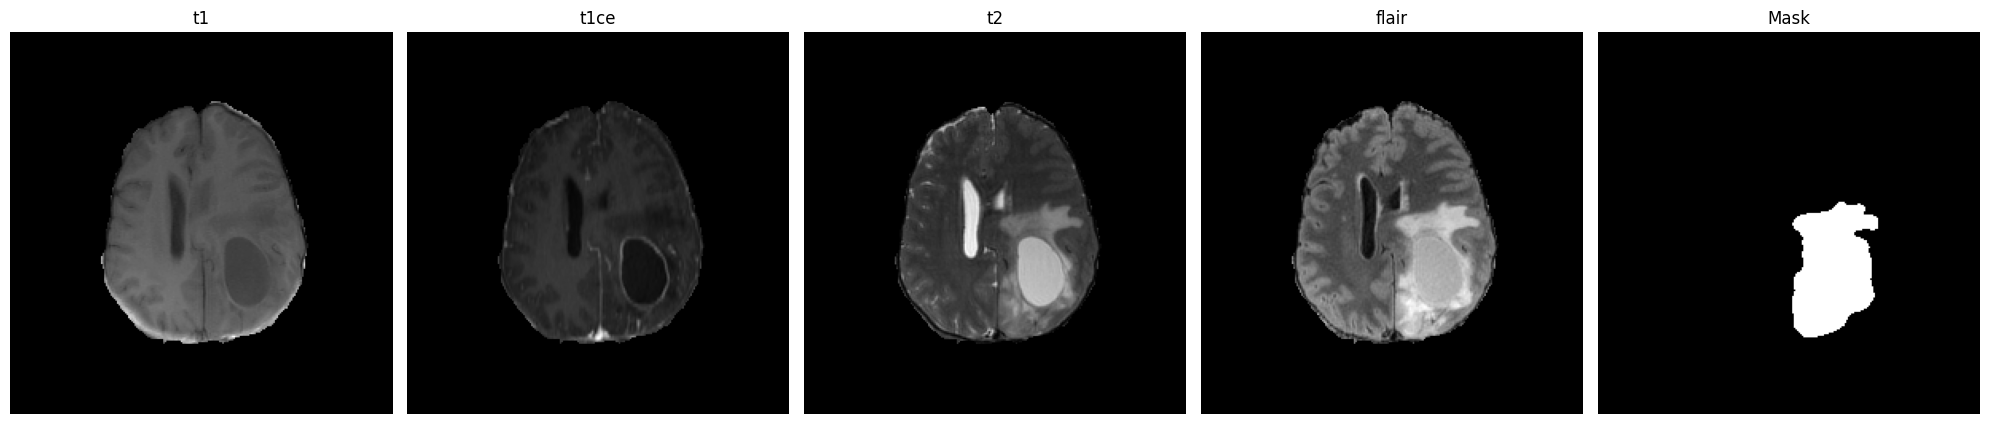

In [ ]:
import numpy as np
from PIL import Image
import os
import tensorflow as tf

SEQUENCES = ["t1", "t1ce", "t2", "flair"]
MASKS = "masks"

# Definir rutas base
base_dir = "data"
train_dir = os.path.join(base_dir, "training_data")
val_dir = os.path.join(base_dir, "validation_data")

def load_instances(path):
    instance_ids = sorted([f.replace('_t1.png', '') for f in sorted(os.listdir(os.path.join(path, 't1'))) if f.endswith(".png")])
    sequences = []
    masks = []

    for instance_id in instance_ids:
        sequence_paths = [os.path.join(path, seq, f"{instance_id}_{seq}.png") for seq in SEQUENCES]
        seg_path = os.path.join(path, MASKS, f"{instance_id}_seg.png")
        sequences.append(sequence_paths)
        masks.append(seg_path)

    return sequences, masks


def process_instance(sequence_paths, seg_path):
    # Secuencias en canales
    images = tf.map_fn(tf.io.read_file, sequence_paths, dtype=tf.string)
    images = tf.map_fn(lambda z: tf.image.decode_png(z, channels=1), images,
                       dtype=tf.uint8)
    images = tf.squeeze(images, axis=-1)
    images = tf.transpose(images, [1, 2, 0])
    images = tf.cast(images, tf.float32) / 255.0

    # Máscara
    mask = tf.io.read_file(seg_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask > 0, tf.float32)

    return images, mask

def get_dataset(path):
    sequences, masks = load_instances(path)

    dataset = tf.data.Dataset.from_tensor_slices((sequences, masks))
    dataset = dataset.map(lambda mods, seg: process_instance(mods, seg))
    dataset = dataset.map(lambda image, mask: (tf.image.resize(image, [240, 240]), mask))

    return dataset


train_dataset = get_dataset(train_dir)
train_dataset = train_dataset.shuffle(buffer_size=1000, seed=RANDOM_SEED)
validation_dataset = get_dataset(val_dir)


import matplotlib.pyplot as plt

first_image, first_mask = next(iter(train_dataset))
first_image, first_mask = first_image.numpy(), first_mask.numpy().squeeze()

# Mostrar las secuencias y la máscara de la primera instancia
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(first_image[:, :, i], cmap='gray')
    axs[i].set_title(SEQUENCES[i])
    axs[i].axis("off")

axs[4].imshow(first_mask, cmap='gray')
axs[4].set_title("Mask")
axs[4].axis("off")

plt.tight_layout()
plt.show()

### Cálculos de coenficiente de similitud *dice*

A continuación se cargan en el notebook las dos implementaciones dadas en el anexo del enunciado del trabajo para calcular los coeficientes de similitud *dice* dadas dos segmentaciones.

In [3]:
import tensorflow as tf
K = tf.keras.backend

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_coefficient_numpy(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)


Además de estas implementaciones, se va a implementar también una función `dice_coefficient_loss` que permita monitorizar la pérdida durante el entrenamiento de los modelos. De esta manera, mediante el uso de esta función como función de pérdida, se pretende ir mejorando la red neuronal basándonos en el objetivo principal, la mejora del valor del coeficiente de *dice*.

In [4]:
def dice_coefficients_loss(y_true, y_pred, smooth=1):
    return -dice_coefficient(y_true, y_pred, smooth)

## Análisis y procesamiento del conjunto


### Verificación del tamaño de los conjuntos de datos

Esta celda imprime la cantidad de instancias (pacientes) disponibles en los conjuntos de entrenamiento y validación. Así, se conocerá tanto el tamaño de cada partición como la proporción entre entrenamiento y validación.

In [ ]:
print("Número de instancias de entrenamiento:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Número de instancias de validación:", tf.data.experimental.cardinality(validation_dataset).numpy())

Número de instancias de entrenamiento: 994
Número de instancias de validación: 257


### Data augmentation

Esta celda realiza una **aumento de datos** en el conjunto de entrenamiento para mejorar la capacidad de generalización del modelo. Esta técnica que consiste en aplicar transformaciones aleatorias a las imágenes de entrada para crear nuevas variaciones, lo cual ayuda a evitar el sobreajuste y mejora la robustez del modelo. En este trabajo se han utilizado dos transformaciones:


- **Volteo:** La imagen y su máscara asociada se voltean horizontalmente con una probabilidad del 50%. Esto simula variaciones en la orientación del paciente, como la imagen invertida, sin cambiar el diagnóstico.
- **Rotación:** La imagen y la máscara se rotan en múltiplos de 90 grados (0, 90, 180, 270 grados) mediante `tf.image.rot90()`. Este tipo de transformaciones ayudan a que el modelo no dependa de la orientación específica de los tumores.


Las nuevas imágenes generadas se añaden al conjunto de datos de entrenamiento, aumentado así en un 100% el tamaño de este, ya que cada una de las imagenes originales han sufrido alguna transformación.


In [ ]:
import tensorflow as tf

def rotate_images(image, mask):
    # Voltear horizontalmente de manera aleatoria
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Rotar la instancia con un número aleatorio de ángulos rectos.
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)

    return image, mask


rotated_train_dataset = train_dataset.map(rotate_images)

# Combinar los dataset aumentados y originales.
train_dataset = train_dataset.concatenate(rotated_train_dataset)

print("Número de instancias de entrenamiento (con rotaciones):", tf.data.experimental.cardinality(train_dataset).numpy())

Número de instancias de entrenamiento (con rotaciones): 1988


### Preparación de los datos en lotes (batching)

En esta celda se prepara el conjunto de datos para el entrenamiento y la validación dividiéndolos en **lotes** o *batches*. Esta técnica que permite procesar los datos en fragmentos más pequeños, lo cual optimiza la memoria y mejora la eficiencia durante el entrenamiento, especialmente con conjuntos de datos grandes. Dados los recursos de los que se disponen, se ha decidido utilizar un tamaño de lote de 16, lo cual indica que en cada paso de entrenamiento se alimentarán 16 imágenes de MRI y sus correspondientes máscaras al modelo.



In [ ]:
BATCH_SIZE = 16

# Preparar los lotes
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

print(f'Número de lotes del conjunto de entrenamiento: {train_dataset.cardinality().numpy()}')
print(f'Número de lotes del conjunto de validación: {validation_dataset.cardinality().numpy()}')


Número de lotes del conjunto de entrenamiento: 125
Número de lotes del conjunto de validación: 17


## Modelo de red neuronal convolucional

Para este trabajo se ha decidido utilizar una red neuronal convolucional (CNN) ad-hoc para la segmentación de tumores cerebrales. Esta decisión se ha tomado debido a la capacidad limitada de procesamiento del entorno en el que se ha trabajado, ya que tras probar diferentes arquitecturas pre-entrenadas, se ha observado que el tiempo de entrenamiento de estas es muy elevado.

Concretamente, la red neuronal propuesta se compone de una serie de capas convolucionales y de *pooling* que permiten extraer características de las imágenes de entrada. A continuación, se definen las capas de la red neuronal.

### Definición de la arquitectura del modelo CNN

En esta celda se define un modelo de red neuronal convolucional (CNN) para la segmentación de tumores cerebrales, utilizando una arquitectura de *encoder-decoder*. En este tipo de arquitectura la red debe aprender a mapear una imagen de entrada de tamaño fijo a una máscara de salida que indique la presencia de un tumor. La entrada del modelo tiene una forma de `(240, 240, 4)`, lo que indica que las imágenes de entrada son de 240x240 píxeles y tienen 4 canales, correspondientes a las 4 secuencias de MRI (T1, T1ce, T2, FLAIR).

1. En la etapa del codificador se utilizan varias capas convolucionales seguidas de capas de max pooling para extraer características jerárquicas de la imagen. Cada capa convolucional aplica filtros para aprender representaciones de diferentes niveles de complejidad.

2. En la parte central, se aplica una capa convolucional de mayor profundidad (128 filtros) en el centro de la red para aprender representaciones más abstractas de la imagen.
   
3. En la fase del decodificador se utilizan capas de **UpSampling2D** para aumentar el tamaño de la imagen y, a continuación, se aplican capas convolucionales para refinar las características. Esta parte del modelo busca reconstruir la imagen segmentada a partir de las características aprendidas previamente.

4. La capa de salida es una convolución con un solo filtro y activación **sigmoide**, lo que produce una máscara binaria (0 o 1) para cada píxel, indicando si pertenece o no a la región tumoral.


Cabe destacar que se ha utilizado capas de **Dropout** para estudiar el sobreajuste del modelo y el efecto que tienen. Estas capas se han añadido despúes de cada bloque de capas convolucionales, tanto del codificador como del decodificador, así como en el cuello de botella. De esta manera, se busca estudiar cómo mejorar los resultados en la segmentación.

Además, se han utilizado también capas de **BatchNormalization** para favorecer la estabilización del entrenamiento.

In [ ]:
import tensorflow as tf
from keras import layers

def cnn_model_1(input_shape=(240, 240, 4), dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # Reducción de muestreo (Codificador)
    pool1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2,2))(pool1)
    pool1 = layers.BatchNormalization()(pool1)
    pool1 = layers.Dropout(dropout_rate)(pool1)

    pool2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2,2))(pool2)
    pool2 = layers.BatchNormalization()(pool2)
    pool2 = layers.Dropout(dropout_rate)(pool2)

    center = layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    center = layers.BatchNormalization()(center)

    # Aumento de muestreo (Decodificador)
    up3 = layers.UpSampling2D((2,2))(center)
    up3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(up3)

    up4 = layers.UpSampling2D((2,2))(up3)
    up4 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(up4)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(up4)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

model = cnn_model_1()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 240, 240, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 120, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 120, 120, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 240, 240, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 240, 240, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 240, 240, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,721 (729.38 KB)

 Trainable params: 186,273 (727.63 KB)

 Non-trainable params: 448 (1.75 KB)

### Visualización del modelo

Haciendo uso de la función plot_model de la libería de tensorflow, se puede visualizar el modelo implementado de una forma gráfica en vez de textual. De esta manera, se puede observar el esquema lineal mencionado.

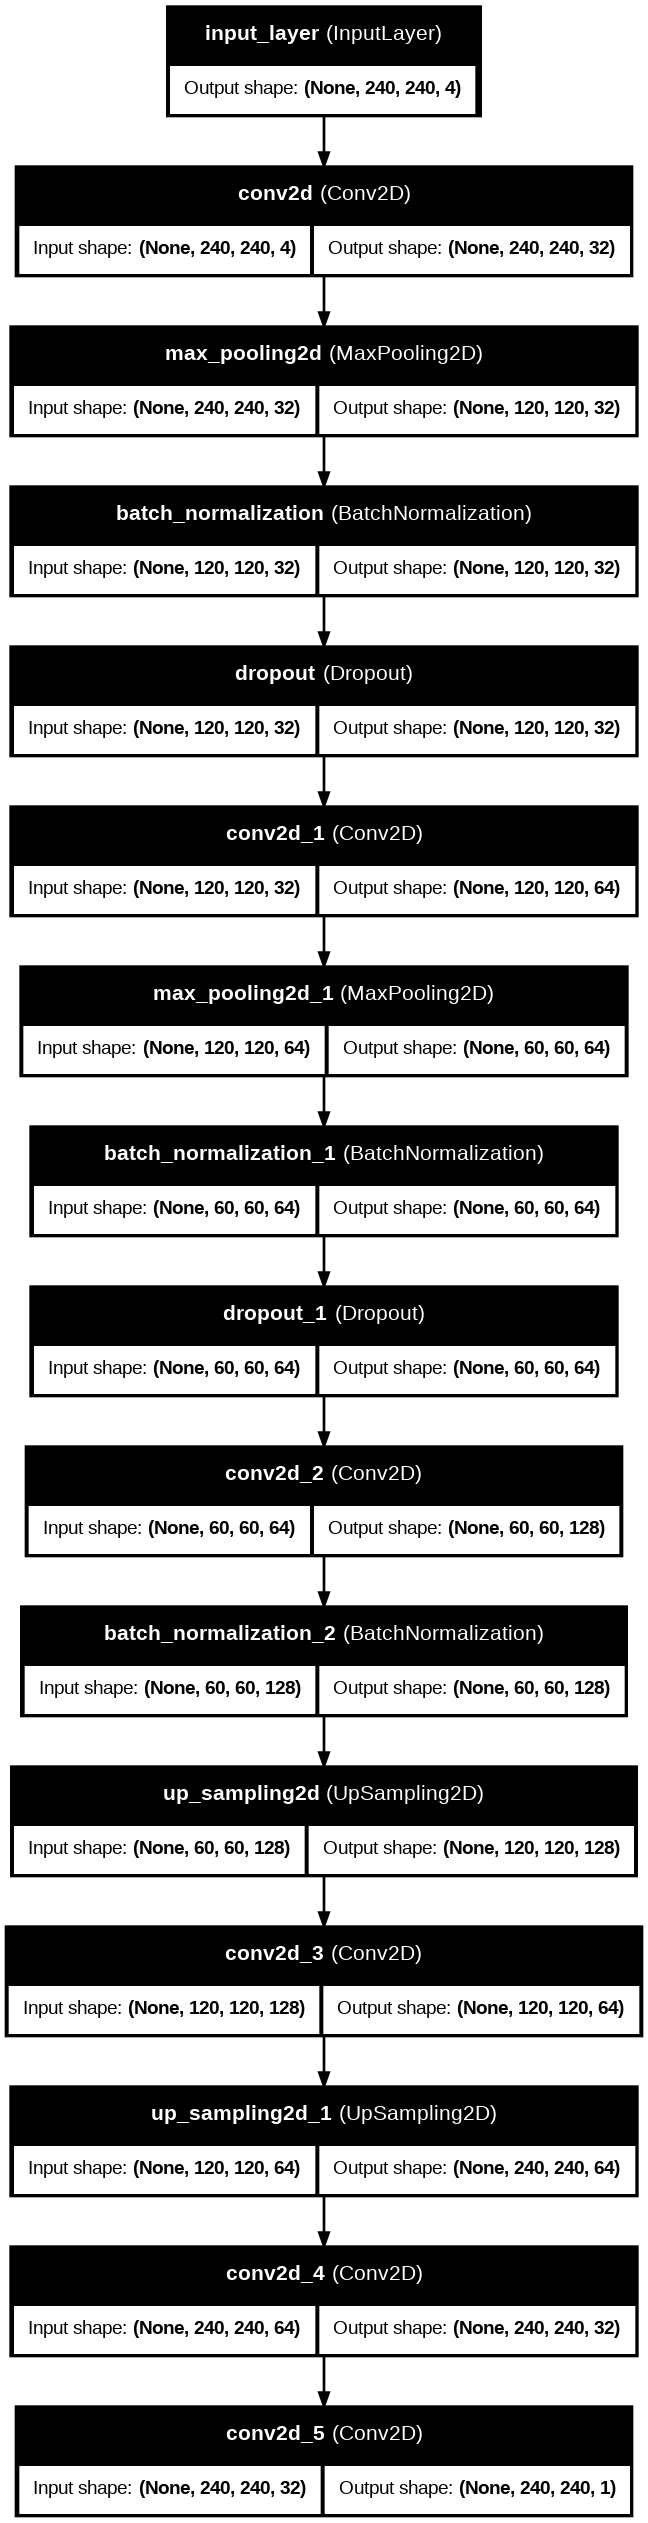

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualizar el modelo
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,
)

### Entrenamiento del modelo con Early Stopping

En esta celda se define la función `train_1()` para entrenar el modelo de segmentación utilizando el conjunto de datos de entrenamiento y validación. Además, se incluye el uso de la técnica **Early Stopping** para evitar el sobreajuste y mejorar la eficiencia del entrenamiento ya que si el modelo no mejora durante un número específico de épocas, definido por el parámetro `patience`, debido a la configuración `restore_best_weights=True`, el modelo se revertirá automáticamente a los mejores pesos obtenidos durante el entrenamiento antes de que se haya detenido, garantizando que el modelo final sea el de mejor rendimiento.

El modelo implementado se compila utilizando el optimizador **Adam**, con una tasa de aprendizaje muy pequeña de `1e-6`, lo que asegura un entrenamiento muy suave y gradual. Por otra parte, la función de pérdida utilizada es `dice_coefficients_loss`, que busca maximiza la similitud entre la máscara predicha y la real (medida a través del coeficiente dice). Se ha introducido el conjunto de validación en el argumento `validation_data` ya que, según la documentación de TensorFlow, este conjunto solo se utiliza para validar el funcionamiento del modelo en las diferentes etapas, pero en ningún caso se utiliza para entrenarlo.

Finalmente, la función devuelve el **historial** del entrenamiento, que contiene información sobre la pérdida y las métricas en cada época, útil para posteriormente analizar el progreso del modelo y realizar ajustes con respecto al segundo modelo.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def train_1(model, train_dataset, validation_dataset, epochs=25, patience=5):
    # Definir el callback de Early Stopping
    early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=1e-6),
                loss=dice_coefficients_loss,
                metrics=[dice_coefficient, 'accuracy'])

    # Entrenar el modelo
    results = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
        batch_size=BATCH_SIZE
    )

    return results.history

### Entrenamiento con diferentes tasas de Dropout

Esta celda entrena el modelo CNN con distintas tasas de **dropout** (de 0.00 a 0.20) para evaluar su impacto en el rendimiento. Los modelos y sus historiales de entrenamiento se guardan en los directorios `models/` y `histories/` respectivamente.

1. **Bucle de entrenamiento:** Se entrenan 5 modelos con tasas de dropout que varían de `0.00` a `0.20`, almacenando tanto los modelos como sus historiales en archivos `keras` y `csv` para compararlos y analizar su rendimiento.

El objetivo es determinar cómo el dropout afecta la capacidad de generalización del modelo.


In [ ]:
import pandas as pd
import os
from google.colab import files

complete_history = []
os.makedirs('models/cnn1', exist_ok=True)
os.makedirs('histories/cnn1', exist_ok=True)

def create_and_train_1(dropout):
    # Definir y entrenar el modelo
    model = cnn_model_1(dropout_rate=dropout)
    history = train_1(model, train_dataset, validation_dataset, epochs=50)
    complete_history.append(history)
    # Guardar modelo entrenado
    model_filename = f'models/cnn1/cnn_model_1_dropout_{str(dropout).replace(".", "_")}.keras'
    model.save(model_filename)
    files.download(model_filename)
    # Guardar el historial del entrenamiento
    history_filename = f'histories/cnn1/cnn_model_1_dropout_{str(dropout).replace(".", "_")}.csv'
    pd.DataFrame(history).to_csv(history_filename, index=False)
    files.download(history_filename)

In [ ]:
create_and_train_1(0.00)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - accuracy: 0.8688 - dice_coefficient: 0.1002 - loss: -0.1002 - val_accuracy: 0.9564 - val_dice_coefficient: 0.0800 - val_loss: -0.0788
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8400 - dice_coefficient: 0.1420 - loss: -0.1420 - val_accuracy: 0.9552 - val_dice_coefficient: 0.1075 - val_loss: -0.1057
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8392 - dice_coefficient: 0.1783 - loss: -0.1783 - val_accuracy: 0.9128 - val_dice_coefficient: 0.1564 - val_loss: -0.1531
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 140ms/step - accuracy: 0.8589 - dice_coefficient: 0.2145 - loss: -0.2145 - val_accuracy: 0.8929 - val_dice_coefficient: 0.2115 - val_loss: -0.2078
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.8889 - dice_coefficient: 0.2539 - loss: -0.2539 - val_accuracy: 0.9095 - val_dice_coefficient: 0.2705 - val_loss: -0.2674
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_1(0.05)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - accuracy: 0.4044 - dice_coefficient: 0.0680 - loss: -0.0680 - val_accuracy: 0.7706 - val_dice_coefficient: 0.0893 - val_loss: -0.0876
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.6798 - dice_coefficient: 0.0996 - loss: -0.0996 - val_accuracy: 0.8431 - val_dice_coefficient: 0.1072 - val_loss: -0.1055
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.7940 - dice_coefficient: 0.1373 - loss: -0.1373 - val_accuracy: 0.8022 - val_dice_coefficient: 0.1422 - val_loss: -0.1404
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.8093 - dice_coefficient: 0.1774 - loss: -0.1774 - val_accuracy: 0.8084 - val_dice_coefficient: 0.1797 - val_loss: -0.1771
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.8389 - dice_coefficient: 0.2208 - loss: -0.2208 - val_accuracy: 0.8574 - val_dice_coefficient: 0.2356 - val_loss: -0.2327
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_1(0.10)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 190ms/step - accuracy: 0.0793 - dice_coefficient: 0.1083 - loss: -0.1083 - val_accuracy: 0.0671 - val_dice_coefficient: 0.0888 - val_loss: -0.0871
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.2699 - dice_coefficient: 0.1169 - loss: -0.1169 - val_accuracy: 0.6387 - val_dice_coefficient: 0.1028 - val_loss: -0.1004
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.5619 - dice_coefficient: 0.1302 - loss: -0.1302 - val_accuracy: 0.6552 - val_dice_coefficient: 0.1241 - val_loss: -0.1211
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.6674 - dice_coefficient: 0.1448 - loss: -0.1448 - val_accuracy: 0.7004 - val_dice_coefficient: 0.1473 - val_loss: -0.1440
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.6937 - dice_coefficient: 0.1623 - loss: -0.1623 - val_accuracy: 0.7146 - val_dice_coefficient: 0.1747 - val_loss: -0.1709
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_1(0.15)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.4242 - dice_coefficient: 0.0810 - loss: -0.0810 - val_accuracy: 0.2199 - val_dice_coefficient: 0.0809 - val_loss: -0.0795
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 145ms/step - accuracy: 0.5686 - dice_coefficient: 0.1030 - loss: -0.1030 - val_accuracy: 0.7461 - val_dice_coefficient: 0.0840 - val_loss: -0.0826
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.6930 - dice_coefficient: 0.1242 - loss: -0.1242 - val_accuracy: 0.7758 - val_dice_coefficient: 0.0958 - val_loss: -0.0941
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.7379 - dice_coefficient: 0.1416 - loss: -0.1416 - val_accuracy: 0.7581 - val_dice_coefficient: 0.1234 - val_loss: -0.1208
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.7510 - dice_coefficient: 0.1608 - loss: -0.1608 - val_accuracy: 0.7569 - val_dice_coefficient: 0.1686 - val_loss: -0.1650
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_1(0.20)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.9502 - dice_coefficient: 0.0512 - loss: -0.0512 - val_accuracy: 0.9524 - val_dice_coefficient: 0.0792 - val_loss: -0.0779
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9422 - dice_coefficient: 0.0845 - loss: -0.0845 - val_accuracy: 0.9560 - val_dice_coefficient: 0.0867 - val_loss: -0.0853
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.9198 - dice_coefficient: 0.1311 - loss: -0.1311 - val_accuracy: 0.9424 - val_dice_coefficient: 0.1126 - val_loss: -0.1109
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.8908 - dice_coefficient: 0.1748 - loss: -0.1748 - val_accuracy: 0.8819 - val_dice_coefficient: 0.1643 - val_loss: -0.1614
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.8750 - dice_coefficient: 0.2122 - loss: -0.2122 - val_accuracy: 0.8599 - val_dice_coefficient: 0.2194 - val_loss: -0.2157
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualización de Resultados del Entrenamiento

Esta celda genera dos gráficos para evaluar el rendimiento de los modelos entrenados con diferentes tasas de **dropout**:

1. **Gráfico del Coeficiente Dice de Validación:**
   - Se trazan las curvas de validación del **Dice Coefficient** para los diferentes modelos con distintas tasas de dropout, lo que permite comparar su rendimiento en la tarea de segmentación.

2. **Gráfico Detallado del Mejor Modelo:**
   - Se selecciona el modelo con el mejor coeficiente **Dice** de validación al final del entrenamiento y se muestran:
     - El **Coeficiente Dice** de entrenamiento y validación, junto con una línea de **baseline** (`Dice = 0.6`).
     - La **pérdida (Loss)** de entrenamiento y validación.

Estos gráficos permiten visualizar cómo se comportaron los modelos durante el entrenamiento y comparar su desempeño con un valor base (`Dice = 0.6`), que es el umbral para un modelo aceptable.


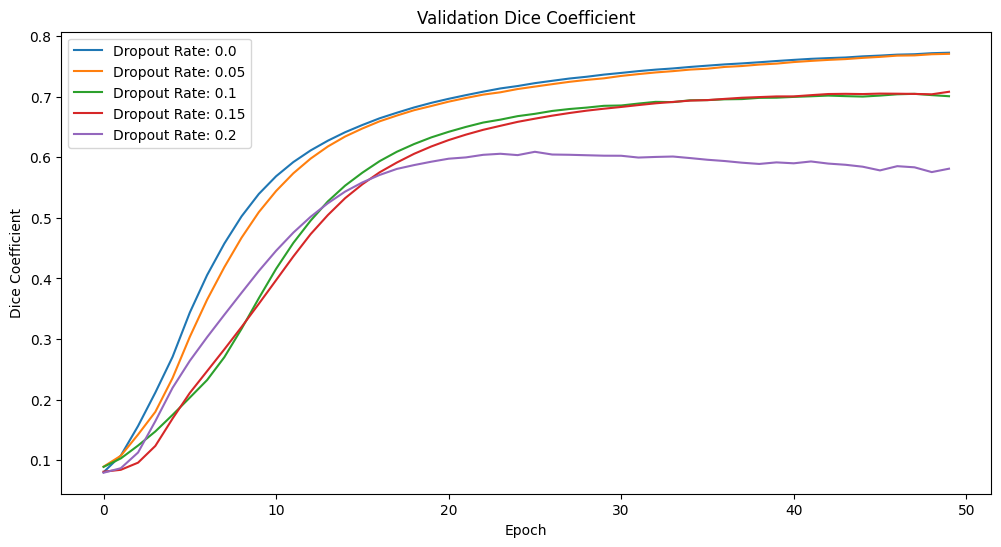

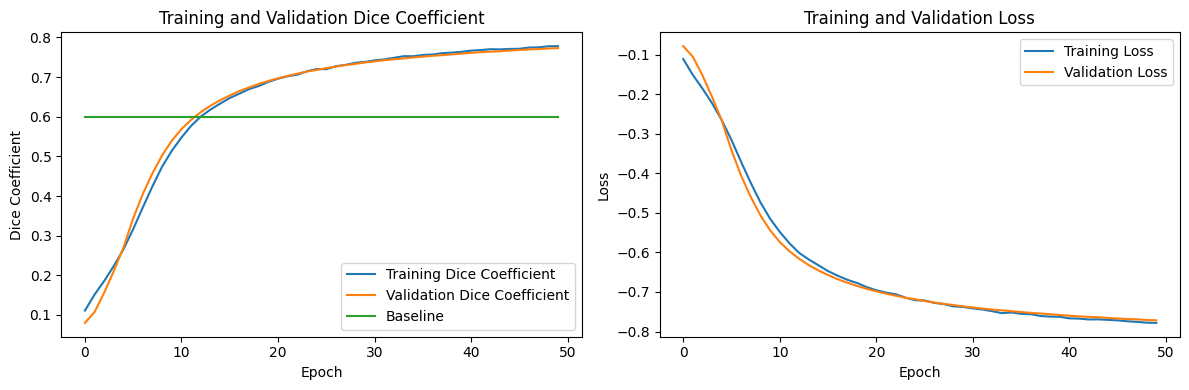

In [ ]:
# Mostrar comparativa de resultados de todos los entrenamientos
plt.figure(figsize=(12, 6))
for i, history in enumerate(complete_history):
    plt.plot(history['val_dice_coefficient'], label=f'Dropout Rate: {i/20}')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice Coefficient')
plt.legend()
plt.show()

best_value = max([history['val_dice_coefficient'][-1] for history in complete_history])
best_index = [history['val_dice_coefficient'][-1] for history in complete_history].index(best_value)
best_history = complete_history[best_index]

# Mostrar progreso del valor de dice
plt.figure(figsize=(12, 4))

# Mostrar comparativa de dice en entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(best_history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(best_history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.plot([0.6 for _ in range(len(best_history['val_dice_coefficient']))], label='Baseline')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()

# Mostrar progreso de la función de pérdida
plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Como se ha podido observar en el primer gráfico, el modelo con un *dropout* del 0.0 ha obtenido el mejor valor para el coeficiente de similitud *dice*, el cual sería de aproximadamente 0.8. Además, el rendimiento del modelos respecto al valor del parámetro dropout ha ido en decaimiento, donde incluso el entrenamiento con `dropout=0.2` no ha conseguido superar el baseline de 0.6.

Los resultados obtenidos por el modelo con `dropout=0.0` son bastante buenos, ya que se ha conseguido superar el baseline dado en el enunciado del trabajo con una CNN simple, por lo que a continuación se va a evaluar las métricas obtenidas por este modelo.





### Carga y Evaluación de Modelos

Esta celda, tras cargar cada modelo, carga también su historial para extraer el **coeficiente Dice de validación** final. Con esta información, se acaba obteniendo el modelo con mejor coeficiente *dice* para la futura comparación con el sigueinte modelo que se realice.

In [ ]:
import os
import tensorflow as tf
import pandas as pd


models = {}
models_dir = os.path.join("models","cnn1")
best_model = (None, "", -1)
histories = {}
histories_dir = os.path.join("histories","cnn1")

for filename in os.listdir(models_dir):
    if filename.endswith(".keras"):
        # Cargar modelos
        model_path = os.path.join(models_dir, filename)
        model_name = filename[:-6]  # Remove the ".keras" extension
        history_path = os.path.join(histories_dir, f'{model_name}.csv')
        models[model_name] = tf.keras.models.load_model(
            model_path, custom_objects={
                'dice_coefficient': dice_coefficient,
                'dice_coefficients_loss': dice_coefficients_loss
            }
        )
        val_dice = "?"
        if os.path.exists(history_path):
            # Cargar historial
            hist_df = pd.read_csv(history_path)
            histories[model_name] = hist_df
            val_dice = histories[model_name]['val_dice_coefficient'].iloc[-1]

        # Actualizar mejor modelo obtenido
        if val_dice > best_model[2]:
            best_model = (models[model_name], model_name, val_dice, histories[model_name])

        print(f'Model: {model_name}\tDice Coefficient: {val_dice}')

# Guardar mejor modelo cnn_1
cnn_1 = {
    "model": best_model[0],
    "model_name": best_model[1],
    "val_dice": best_model[2],
    "history": best_model[3]
}
print(f'\nBest model: {cnn_1["model_name"]}\tDice Coefficient: {cnn_1["val_dice"]}')

model = cnn_1["model"]

Model: cnn_model_1_dropout_0_2	Dice Coefficient: 0.5813175439834595
Model: cnn_model_1_dropout_0_0	Dice Coefficient: 0.7728545665740967
Model: cnn_model_1_dropout_0_05	Dice Coefficient: 0.7710222005844116
Model: cnn_model_1_dropout_0_1	Dice Coefficient: 0.7010024785995483
Model: cnn_model_1_dropout_0_15	Dice Coefficient: 0.7083631157875061

Best model: cnn_model_1_dropout_0_0	Dice Coefficient: 0.7728545665740967


### Evaluación del Modelo en el Conjunto de Validación

A continuación se realizan predicciones sobre el conjunto de validación y evalúa el rendimiento del modelo usando el **coeficiente de Dice**. Tras esto, se muestran algunas predicciones junto con las secuencias T1 originales y sus máscaras reales para inspección cualitativa de resultados.


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step
Predicted masks: 257	Dice Coefficient: 0.7369631147864567


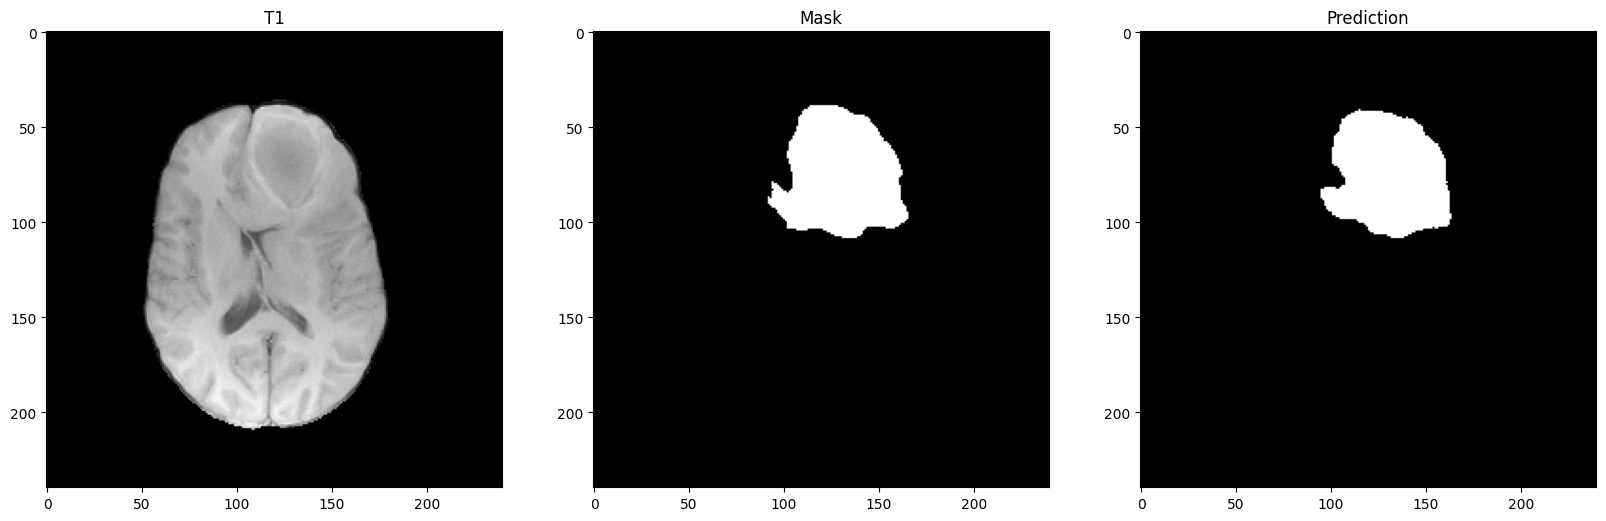

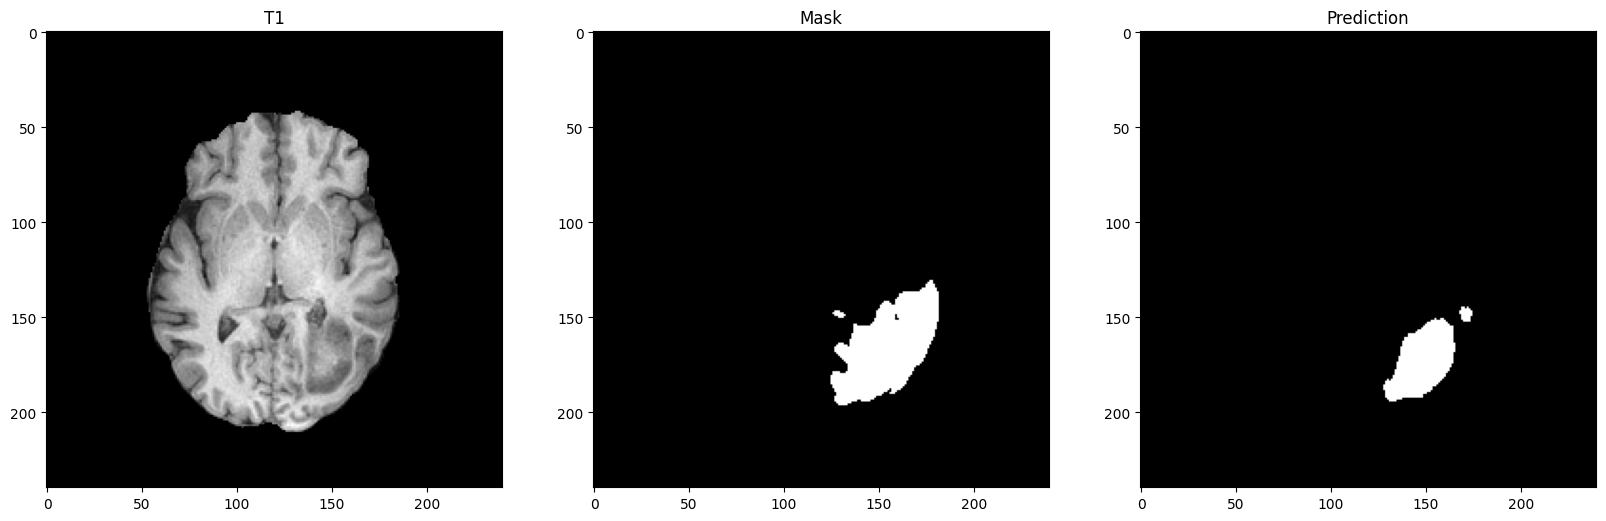

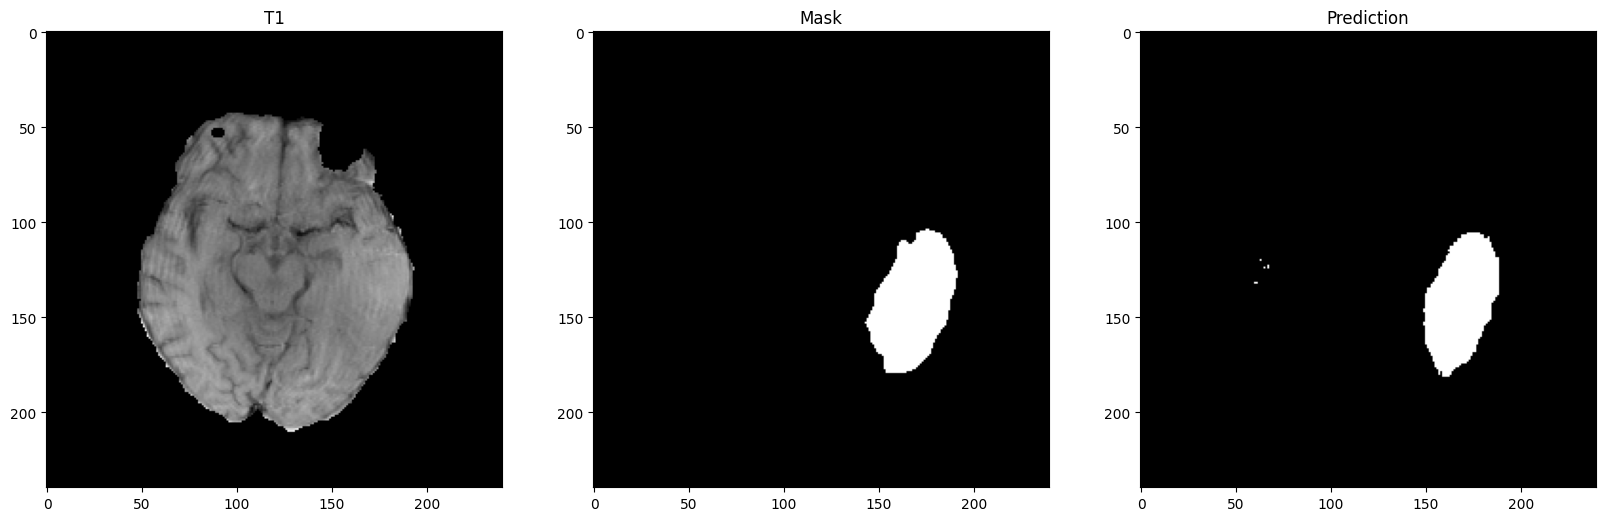

In [ ]:
# Calcular el coeficiente de Dice
dice_coefficient_values = []
image_history = []

# Realizar predicciones en todo el conjunto de datos de prueba
predictions = model.predict(validation_dataset)

# Calcular el coeficiente de Dice para cada máscara y obtener el promedio
for batch_index, (sequences, true_mask) in enumerate(validation_dataset):
    for instance_index in range(sequences.shape[0]):
        prediction_index = batch_index * BATCH_SIZE + instance_index
        # Umbralizar la predicción para obtener una máscara binaria
        predicted_mask = (predictions[prediction_index] > 0.5).astype(np.uint8)

        # Obtener las secuencias y la máscara real correspondiente para la instancia actual
        instance_sequences = sequences[instance_index].numpy()
        instance_true_mask = true_mask[instance_index].numpy()

        # Calcular el coeficiente de Dice usando la función dice_coefficient_numpy
        dice = dice_coefficient_numpy(instance_true_mask, predicted_mask)
        dice_coefficient_values.append(dice)

        # Almacenar las imagenes
        image_history.append((instance_sequences, instance_true_mask, predicted_mask))

print(f'Predicted masks: {len(predictions)}\tDice Coefficient: {np.mean(dice_coefficient_values)}')

# Visualizar algunas predicciones
for i in range(min(3, len(image_history))):
    sequences, mask, prediction = image_history[i]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.imshow(sequences[:, :, 0], cmap='gray')
    ax1.set_title('T1')
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask')
    ax3.imshow(prediction, cmap='gray')
    ax3.set_title('Prediction')
    plt.show()

Como se puede observar, el modelo es capaz de detectar las regiones tumorales del cerebro, sin llegar a ocupar todo el area en algunas de las instancias. Aun así, al modelo todavía le falta definición en cuanto a las máscaras que genera, puesto que son áreas muy suavizadas y que, por lo tanto, dependiendo de la forma, dejan zonas relevantes sin identificar.

## CNN con Arquitectura Profunda

Con el objetivo de perfeccionar el rendimiento del primer modelo de capas convolucionales, se va a diseñar una nueva CNN con arquitectura profunda.

### Definición de la CNN con Arquitectura Profunda

Se define una red convolucional profunda para la segmentación de tumores, que se encuentra inspirada en la arquitectura **U-Net**. Una de las características que la hace especialmente efectiva para tareas de segmentación médica es el uso de **conexiones de salto** o *skip connections*, los cuales permiten preservar detalles especialmente importantes del encoder al decoder.

- **Codificador**: Se encarga de extraer características jerárquicas mediante bloques convolucionales con pooling, batch normalization y regularización por dropout.
- **Centro**: Bloque de mayor profundidad que captura representaciones semánticas más complejas.
- **Decoficador**: Se restaura la resolución espacial mediante upsampling y concatenación con capas previas del encoder, facilitando la reconstrucción detallada de la segmentación.
- **Capa de salida**: Conv2D con activación **sigmoide** para generar una máscara binaria.

Este modelo es más complejo que el anterior (`cnn_model_1`) y está diseñado para mejorar la precisión en la segmentación de estructuras tumorales pequeñas y con bordes difusos.

In [ ]:
import tensorflow as tf
from keras import layers

def cnn_model_2(input_shape=(240, 240, 4), dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)  # Capa de entrada

    # Reducción de muestreo (Codificador)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.BatchNormalization()(pool1)
    pool1 = layers.Dropout(dropout_rate)(pool1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.BatchNormalization()(pool2)
    pool2 = layers.Dropout(dropout_rate)(pool2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.BatchNormalization()(pool3)
    pool3 = layers.Dropout(dropout_rate)(pool3)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.BatchNormalization()(pool4)
    pool4 = layers.Dropout(dropout_rate)(pool4)

    center = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    center = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(center)
    center = layers.BatchNormalization()(center)

    # AMpliación de muestreo (Decodificador)
    up5 = layers.UpSampling2D((2, 2))(center)
    up5 = layers.concatenate([up5, conv4])  # Skip connection
    up5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    up5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    up5 = layers.BatchNormalization()(up5)
    up5 = layers.Dropout(dropout_rate)(up5)

    up6 = layers.UpSampling2D((2, 2))(up5)
    up6 = layers.concatenate([up6, conv3])  # Skip connection
    up6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    up6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.Dropout(dropout_rate)(up6)

    up7 = layers.UpSampling2D((2, 2))(up6)
    up7 = layers.concatenate([up7, conv2])  # Skip connection
    up7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    up7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.Dropout(dropout_rate)(up7)

    up8 = layers.UpSampling2D((2, 2))(up7)
    up8 = layers.concatenate([up8, conv1])  # Skip connection
    up8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    up8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    up8 = layers.BatchNormalization()(up8)
    up8 = layers.Dropout(dropout_rate)(up8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up8)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

model = cnn_model_2()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 240,  │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 240, 240,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 120,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 120, 120,  │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 120, 120,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 60, 60,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 60,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 30,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │    295,168 │ dropout_2[0][0] 

 Total params: 7,852,833 (29.96 MB)

 Trainable params: 7,849,889 (29.94 MB)

 Non-trainable params: 2,944 (11.50 KB)

### Visualización de la Arquitectura del Modelo

Se utiliza `plot_model` de Keras para **generar un diagrama visual** de la arquitectura de `cnn_model_2`. De esta manera se puede ver claramente la estructura del modelo, especialmente la forma de U rotada por las *skip connections*. Por lo tanto, este diagrama proporciona una visión de alto nivel del flujo de datos en la red y facilita la comprensión de su complejidad estructural.


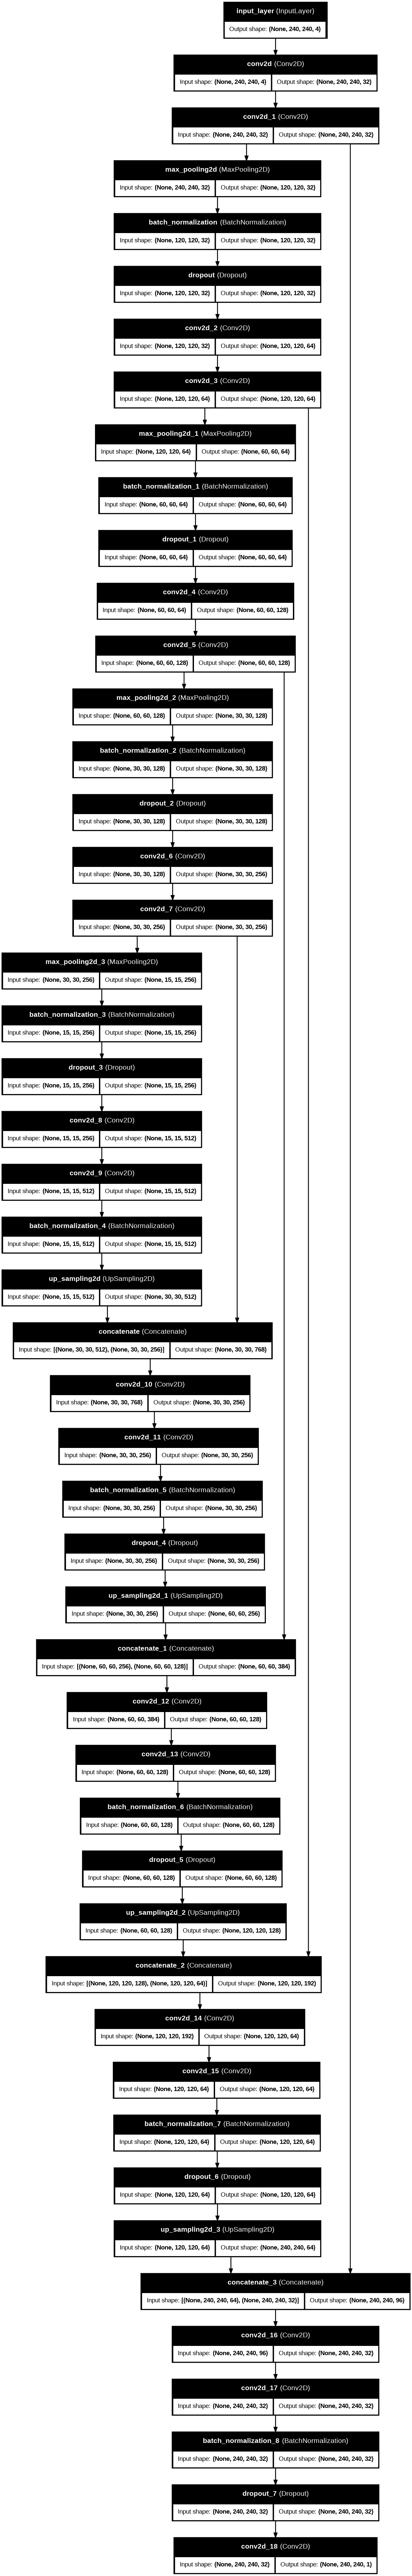

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualizar el modelo
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,
)

### Entrenamiento Avanzado de la CCN

La nueva función de entrenamiento `train_2` implementa un enfoque en dos fases para el modelo `cnn_model_2`, combinando una optimización y técnicas de fine-tuning:

La primera fase proporciona un **entrenamiento onicial** que entrena el modelo completo desde cero con optimización `Adam` a una tasa de aprendizaje de `1e-4`, además de `EarlyStopping` monitorizando la pérdida (`loss`) con `patience=5`.

Por otra parte, la segunda fase porporciona una etapa de *fine-tuning* donde se congelan las primeras capas del modelo (las 5 iniciales), asumiendo que contienen representaciones generales útiles obtenidas en la primera etapas. El resto del modelo se entrena con una tasa de aprendizaje más baja (`1e-6`) para realizar ajustes finos sin desestabilizar los pesos aprendidos.

Este enfoque busca mejorar la estabilidad del entrenamiento y maximizar el rendimiento general del modelo, además de combinar los historiales (`history_1` y `history_2`) para obtener una curva completa del entrenamiento.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def train_2(model, train_dataset, validation_dataset, epochs=25, patience=5):
    # Definir el callback de Early Stopping
    early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=1e-4),
                loss=dice_coefficients_loss,
                metrics=[dice_coefficient, 'accuracy'])

    # Entrenar el modelo
    history_1 = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs//2,
        callbacks=[early_stopping],
        batch_size=BATCH_SIZE
    )

    # Congelar las primeras 15 capas
    for layer in model.layers[:5]:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=1e-6),
                loss=dice_coefficients_loss,
                metrics=[dice_coefficient, 'accuracy'])

    # Entrenar el modelo
    history_2 = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        initial_epoch=len(history_1.epoch),
        callbacks=[early_stopping],
        batch_size=BATCH_SIZE
    )

    # Combine the training histories
    history = {}
    for key, value in history_1.history.items():
        history[key] = value + history_2.history[key]

    return history

### Ajuste de Dropout en CNN

Este experimento entrena múltiples versiones del modelo `cnn_model_2`, variando el parámetro `dropout_rate` de 0.00 a 0.20 (en incrementos de 0.05). Se entrena usando la función `train_2`, almacenando el modelo entrenado en la carpeta `models/` y exportando el historial del entrenamiento (`loss`, `accuracy`, `dice_coefficient`) como CSV en `histories/`.

Esto permite analizar cómo afecta la regularización mediante *dropout* al rendimiento del modelo en validación introducido nuevamente en el argumento `validation_data`.

In [ ]:
import pandas as pd
import os
from google.colab import files

complete_history = []
os.makedirs('models/cnn2', exist_ok=True)
os.makedirs('histories/cnn2', exist_ok=True)

def create_and_train_2(dropout, epochs=50):
    # Crear y entrenar el modelo
    model = cnn_model_2(dropout_rate=dropout)
    history = train_2(model, train_dataset, validation_dataset, epochs=epochs)
    complete_history.append(history)
    # Guardar el modelo entrenado
    model_filename = f'models/cnn2/cnn_model_2_dropout_{str(dropout).replace(".", "_")}.keras'
    model.save(model_filename)
    files.download(model_filename)
    # Guardar el historial del entrenamiento
    history_filename = f'histories/cnn2/cnn_model_2_dropout_{str(dropout).replace(".", "_")}.csv'
    pd.DataFrame(history).to_csv(history_filename, index=False)
    files.download(history_filename)

In [ ]:
create_and_train_2(0.00)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 618ms/step - accuracy: 0.8249 - dice_coefficient: 0.2639 - loss: -0.2639 - val_accuracy: 0.9564 - val_dice_coefficient: 0.0426 - val_loss: -0.0423
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 334ms/step - accuracy: 0.9377 - dice_coefficient: 0.4095 - loss: -0.4095 - val_accuracy: 0.9773 - val_dice_coefficient: 0.6210 - val_loss: -0.6149
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 337ms/step - accuracy: 0.9533 - dice_coefficient: 0.4601 - loss: -0.4601 - val_accuracy: 0.9510 - val_dice_coefficient: 0.6081 - val_loss: -0.6023
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 327ms/step - accuracy: 0.9661 - dice_coefficient: 0.5141 - loss: -0.5140 - val_accuracy: 0.9652 - val_dice_coefficient: 0.6746 - val_loss: -0.6711
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 343ms/step - accuracy: 0.9745 - dice_coefficient: 0.5724 - loss: -0.5724 - val_accuracy: 0.9809 - val_dice_coefficient: 0.7831 - val_loss: -0.7793
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_2(0.05)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 485ms/step - accuracy: 0.7893 - dice_coefficient: 0.2365 - loss: -0.2366 - val_accuracy: 0.9564 - val_dice_coefficient: 0.0190 - val_loss: -0.0189
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.9231 - dice_coefficient: 0.3602 - loss: -0.3602 - val_accuracy: 0.9565 - val_dice_coefficient: 0.0099 - val_loss: -0.0100
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 348ms/step - accuracy: 0.9427 - dice_coefficient: 0.4065 - loss: -0.4065 - val_accuracy: 0.9779 - val_dice_coefficient: 0.7000 - val_loss: -0.7197
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 354ms/step - accuracy: 0.9550 - dice_coefficient: 0.4527 - loss: -0.4527 - val_accuracy: 0.9473 - val_dice_coefficient: 0.5805 - val_loss: -0.5881
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 351ms/step - accuracy: 0.9607 - dice_coefficient: 0.4950 - loss: -0.4950 - val_accuracy: 0.9715 - val_dice_coefficient: 0.6874 - val_loss: -0.6861
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_2(0.10)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 516ms/step - accuracy: 0.7422 - dice_coefficient: 0.2225 - loss: -0.2225 - val_accuracy: 0.9564 - val_dice_coefficient: 0.0030 - val_loss: -0.0030
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 358ms/step - accuracy: 0.9180 - dice_coefficient: 0.3669 - loss: -0.3669 - val_accuracy: 0.9624 - val_dice_coefficient: 0.2226 - val_loss: -0.2356
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 338ms/step - accuracy: 0.9420 - dice_coefficient: 0.4247 - loss: -0.4247 - val_accuracy: 0.9694 - val_dice_coefficient: 0.7075 - val_loss: -0.7061
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 351ms/step - accuracy: 0.9547 - dice_coefficient: 0.4713 - loss: -0.4712 - val_accuracy: 0.9517 - val_dice_coefficient: 0.6236 - val_loss: -0.6235
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 341ms/step - accuracy: 0.9643 - dice_coefficient: 0.5191 - loss: -0.5191 - val_accuracy: 0.9411 - val_dice_coefficient: 0.5775 - val_loss: -0.5816
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_2(0.15)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 497ms/step - accuracy: 0.7339 - dice_coefficient: 0.2123 - loss: -0.2123 - val_accuracy: 0.9564 - val_dice_coefficient: 0.0099 - val_loss: -0.0099
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 365ms/step - accuracy: 0.9224 - dice_coefficient: 0.3753 - loss: -0.3753 - val_accuracy: 0.9575 - val_dice_coefficient: 0.0444 - val_loss: -0.0468
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 350ms/step - accuracy: 0.9437 - dice_coefficient: 0.4267 - loss: -0.4267 - val_accuracy: 0.9752 - val_dice_coefficient: 0.7131 - val_loss: -0.7059
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 357ms/step - accuracy: 0.9565 - dice_coefficient: 0.4753 - loss: -0.4753 - val_accuracy: 0.9354 - val_dice_coefficient: 0.5439 - val_loss: -0.5508
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 350ms/step - accuracy: 0.9672 - dice_coefficient: 0.5337 - loss: -0.5337 - val_accuracy: 0.9656 - val_dice_coefficient: 0.6462 - val_loss: -0.6504
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_and_train_2(0.20)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 502ms/step - accuracy: 0.7792 - dice_coefficient: 0.2276 - loss: -0.2276 - val_accuracy: 0.9564 - val_dice_coefficient: 0.0249 - val_loss: -0.0248
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 347ms/step - accuracy: 0.9207 - dice_coefficient: 0.3598 - loss: -0.3597 - val_accuracy: 0.9564 - val_dice_coefficient: 0.0073 - val_loss: -0.0073
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 349ms/step - accuracy: 0.9384 - dice_coefficient: 0.4025 - loss: -0.4025 - val_accuracy: 0.9726 - val_dice_coefficient: 0.6372 - val_loss: -0.6369
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 343ms/step - accuracy: 0.9525 - dice_coefficient: 0.4491 - loss: -0.4491 - val_accuracy: 0.9582 - val_dice_coefficient: 0.6098 - val_loss: -0.6061
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 341ms/step - accuracy: 0.9642 - dice_coefficient: 0.4963 - loss: -0.4964 - val_accuracy: 0.9494 - val_dice_coefficient: 0.5624 - val_loss: -0.5686
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Análisis del Rendimiento del modelo

Para ello, se han representado nuevamente las curvas de validación del coeficiente de Dice (`val_dice_coefficient`) para cada valor de *dropout* probado.

Posteriormente, una vez obtenido el modelo cuyo dropout ha aportado mejores resultados, se representan:

- Las curvas de entrenamiento y validación de `dice_coefficient` del mejor modelo.
- Las curvas de pérdida (`loss`) para analizar sobreajuste o subajuste.
- El *baseline* de referencia en `0.6` para comparar el rendimiento mínimo aceptable.


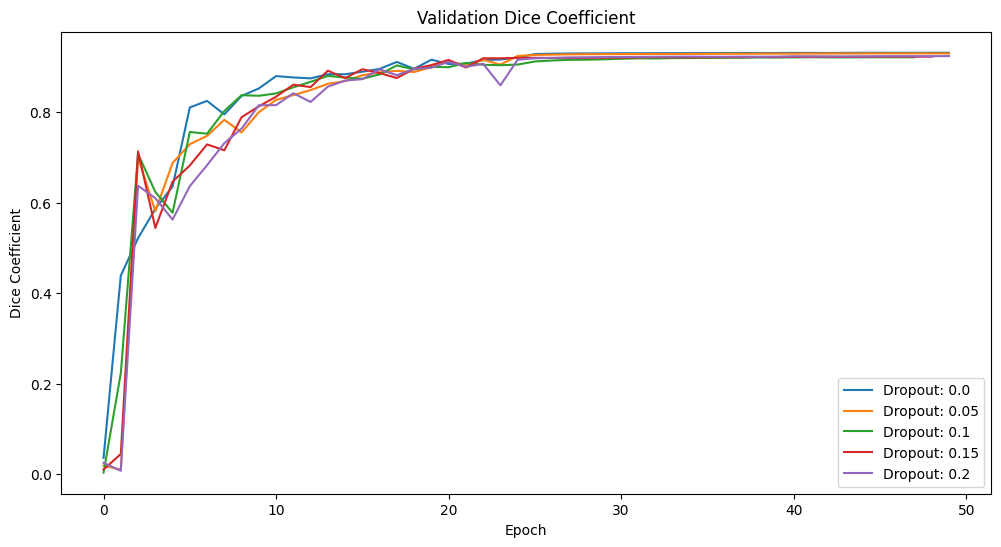

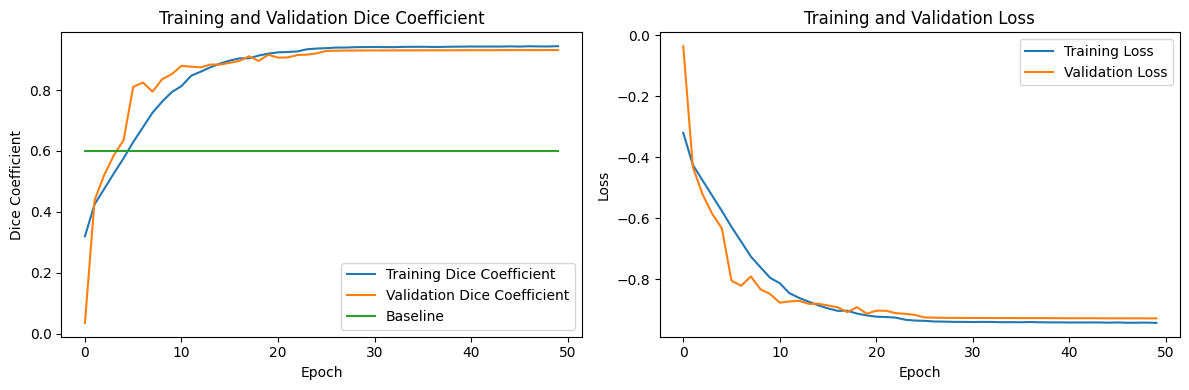

In [ ]:
# Mostrar comparativa de resultados de todos los entrenamientos
plt.figure(figsize=(12, 6))
for i, history in enumerate(complete_history):
    plt.plot(history['val_dice_coefficient'], label=f'Dropout: {i/20}')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice Coefficient')
plt.legend()
plt.show()

best_value = max([history['val_dice_coefficient'][-1] for history in complete_history])
best_index = [history['val_dice_coefficient'][-1] for history in complete_history].index(best_value)
best_history = complete_history[best_index]

# Mostrar progreso del valor de dice
plt.figure(figsize=(12, 4))

# Mostrar comparativa de dice en entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(best_history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(best_history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.plot([0.6 for _ in range(len(best_history['val_dice_coefficient']))], label='Baseline')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()

# Mostrar progreso de la función de pérdida
plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

El rendimiento de este modelo ha sido superior al mostrado por la primera CNN, llegando a superar todas las variaciones del modelo con diferentes valores de dropout el baseline de 0.6 propuesto.

La variante con mayor valor de coeficiente dice ha sido el que cuenta con un valor de `dropout=0.00`. Además, se puede observar que, aunque la mejora el coeficiente dice en el conjunto de entrenamiento ha sido progresivo, en cuanto al valor de dicho coeficiente sobre el conjunto de validación ha sido intermitente, sobre todo en la primera mitas de las etapas, donde el valor subía y bajaba constantemente.

Esto puede deberse a un aprendizaje muy largo con learning rate demasiado grande, por lo que se ha decidido reducir el número de etapas que se ha entrenado el modelo. De esta manera, se entrenarían 12 etapas con un `learning_rate=1e-4` y las posteriores 13 etapas con `learning_rate=1e-6`.

In [ ]:
# Mantener el historial de dropout=0.0
complete_history = complete_history[:1]

# Entrenar el modelo con la mitad de las etapas (25)
epochs = 25
model = cnn_model_2(dropout_rate=0.0)
history = train_2(model, train_dataset, validation_dataset, epochs=epochs)
complete_history.append(history)
model_filename = f'models/cnn2/cnn_model_2_dropout_0_0_epochs_{epochs}.keras'
model.save(model_filename)
files.download(model_filename)
history_filename = f'histories/cnn2/cnn_model_2_dropout_0_0_epochs_{epochs}.csv'
pd.DataFrame(history).to_csv(history_filename, index=False)
files.download(history_filename)

Epoch 1/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 441ms/step - accuracy: 0.7880 - dice_coefficient: 0.2522 - loss: -0.2522 - val_accuracy: 0.9561 - val_dice_coefficient: 0.0498 - val_loss: -0.0494
Epoch 2/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 340ms/step - accuracy: 0.9356 - dice_coefficient: 0.3966 - loss: -0.3966 - val_accuracy: 0.9532 - val_dice_coefficient: 0.0486 - val_loss: -0.0502
Epoch 3/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 335ms/step - accuracy: 0.9524 - dice_coefficient: 0.4549 - loss: -0.4549 - val_accuracy: 0.9684 - val_dice_coefficient: 0.6319 - val_loss: -0.6318
Epoch 4/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 341ms/step - accuracy: 0.9626 - dice_coefficient: 0.5026 - loss: -0.5026 - val_accuracy: 0.9630 - val_dice_coefficient: 0.6286 - val_loss: -0.6283
Epoch 5/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 0.9713 - dice_coefficient: 0.5529 - loss: -0.5529 - val_accuracy: 0.9792 - val_dice_coefficient: 0.7225 - val_loss: -0.7218
Epoch 6/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

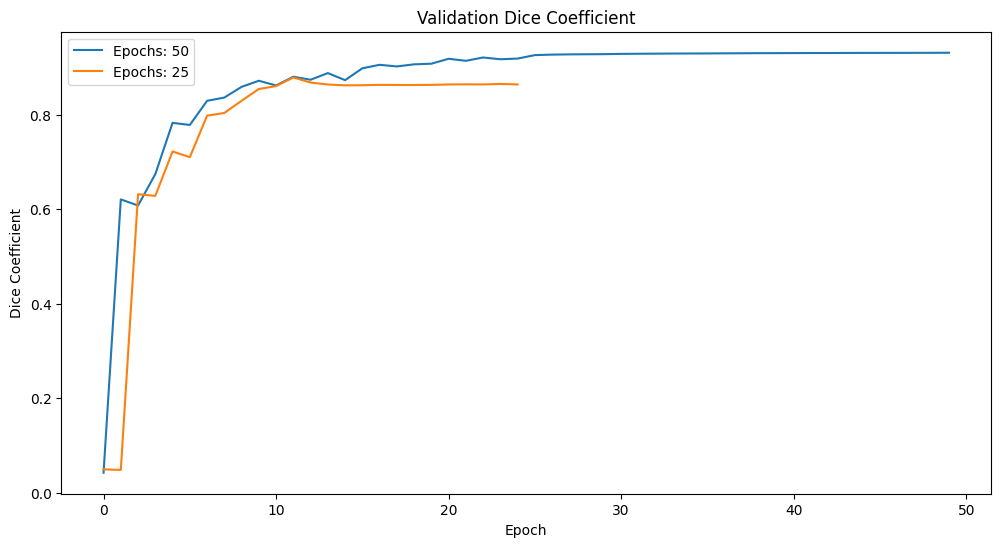

In [ ]:
# Mostrar comparativa de resultados con distinto número de etapas
plt.figure(figsize=(12, 6))
for i, history in enumerate(complete_history):
    plt.plot(history['val_dice_coefficient'], label=f'Epochs: {str(50 - (25*i))}')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice Coefficient')
plt.legend()
plt.show()

Como se puede observar en la figura, el rendimiento del modelo sigue siendo mejor el que realiza las 50 etapas. Por otra parte, el nuevo entrenamiento en 25 etapas muestra como el entrenamiento se queda atascado después de realizar las primeras 12 etapas con un learning rate alto.

### Carga y evaluación de los modelos de modelos entrenados

Esta celda recorre todos los modelos guardados en el directorio `models/cnn2` con extensión `.keras`, los carga incluyendo las funciones personalizadas necesarias (`dice_coefficient` y `dice_coefficients_loss`) junto a su historial correspondiente (`.csv`) en el directorio `histories/cnn2`. Posteriormente, y utilizando el último valor del `val_dice_coefficient`, identifica el modelo con el mejor valor de Dice en validación y lo registra como el mejor modelo encontrado.

In [5]:
import os
import tensorflow as tf
import pandas as pd


models = {}
models_dir = os.path.join("models","cnn2")
best_model = (None, "", -1, None)
histories = {}
histories_dir = os.path.join("histories","cnn2")

for filename in os.listdir(models_dir):
    if filename.endswith(".keras"):
        # Cargar modelos
        model_path = os.path.join(models_dir, filename)
        model_name = filename[:-6]  # Remove the ".keras" extension
        history_path = os.path.join(histories_dir, f'{model_name}.csv')
        models[model_name] = tf.keras.models.load_model(
            model_path, custom_objects={
                'dice_coefficient': dice_coefficient,
                'dice_coefficients_loss': dice_coefficients_loss
            }
        )
        val_dice = "?"
        if os.path.exists(history_path):
            # Cargar historial
            hist_df = pd.read_csv(history_path)
            histories[model_name] = hist_df
            val_dice = histories[model_name]['val_dice_coefficient'].iloc[-1]

        # Actualizar mejor modelo obtenido
        if val_dice > best_model[2]:
            best_model = (models[model_name], model_name, val_dice, histories[model_name])

        print(f'Model: {model_name}\tDice Coefficient: {val_dice}')

# Guardar mejor modelo cnn_1
cnn_2 = {
    "model": best_model[0],
    "model_name": best_model[1],
    "val_dice": best_model[2],
    "history": best_model[3]
}
print(f'\nBest model: {cnn_2["model_name"]}\tDice Coefficient: {cnn_2["val_dice"]}')
model = cnn_2['model']

Model: cnn_model_2_dropout_0_15	Dice Coefficient: 0.9224594235420228
Model: cnn_model_2_dropout_0_0	Dice Coefficient: 0.9314552545547484
Model: cnn_model_2_dropout_0_2	Dice Coefficient: 0.9237173199653624
Model: cnn_model_2_dropout_0_0_epochs_25	Dice Coefficient: 0.8643381595611572
Model: cnn_model_2_dropout_0_05	Dice Coefficient: 0.929636776447296
Model: cnn_model_2_dropout_0_1	Dice Coefficient: 0.9211522340774536

Best model: cnn_model_2_dropout_0_0	Dice Coefficient: 0.9314552545547484


En cuanto a los modelos entrenados durante 50 etapas, todos han obtenido un rendimiento similar, en torno al 0.92 de coeficiente dice, sin embargo el modelo con dropout 0.0 ha conseguido superar el 0.93, obteniendo el mejor valor.

Por otra parte, como se puede comprobar y era de esperar, el modelo entrenado durante menos etapas ha conseguido un coeficiente menor, quedandose en 0.86. Aun así, permite comprobar que el nuevo modelo `cnn_model_2`, aun utilizando la mitad de etapas que el primero, es capaz de obtener mejores resultados.

### Evaluación del Modelo en el Conjunto de Validación

A continuación se realizan predicciones sobre el conjunto de validación y evalúa el rendimiento del modelo usando el **coeficiente de Dice**. Tras esto, se muestran algunas predicciones junto con las secuencias T1 originales y sus máscaras reales para inspección cualitativa de resultados.


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step
Predicted masks: 257	Dice Coefficient: 0.9231175479541052


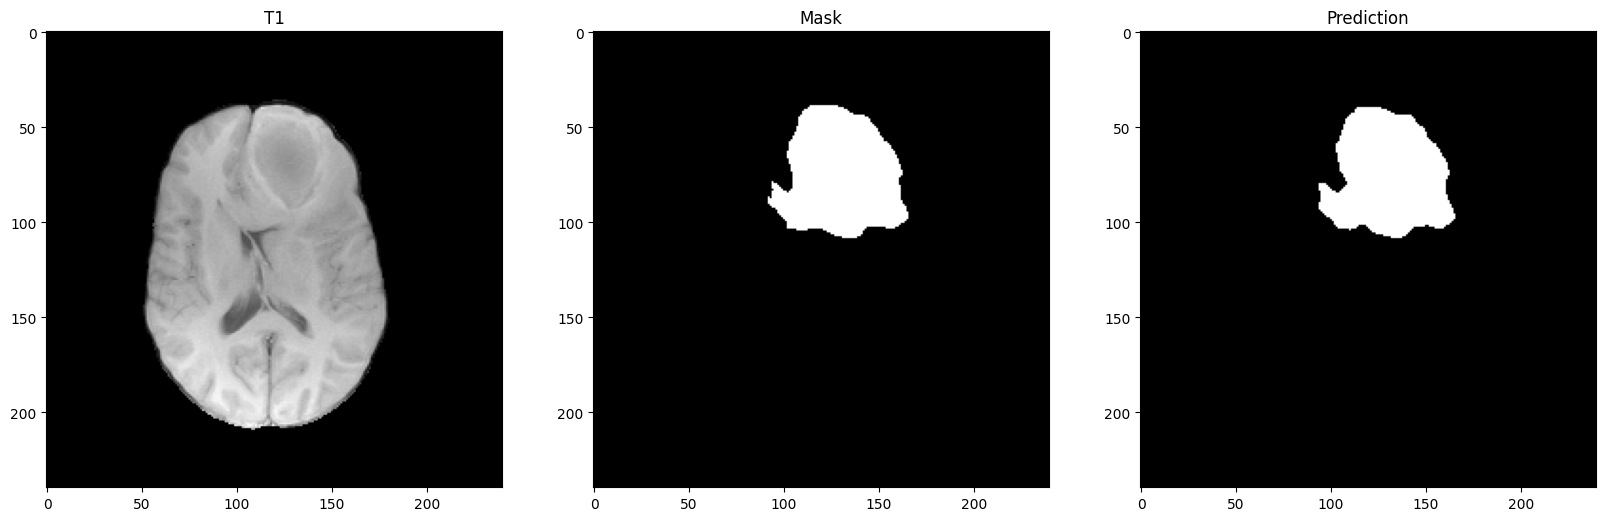

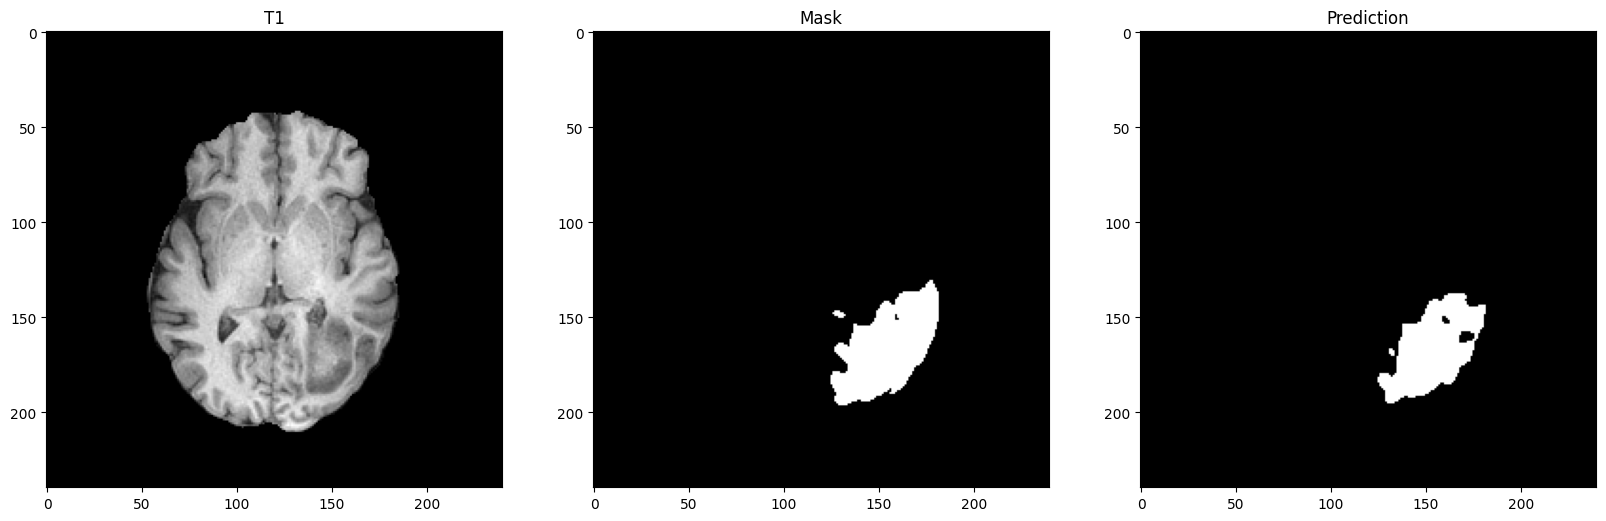

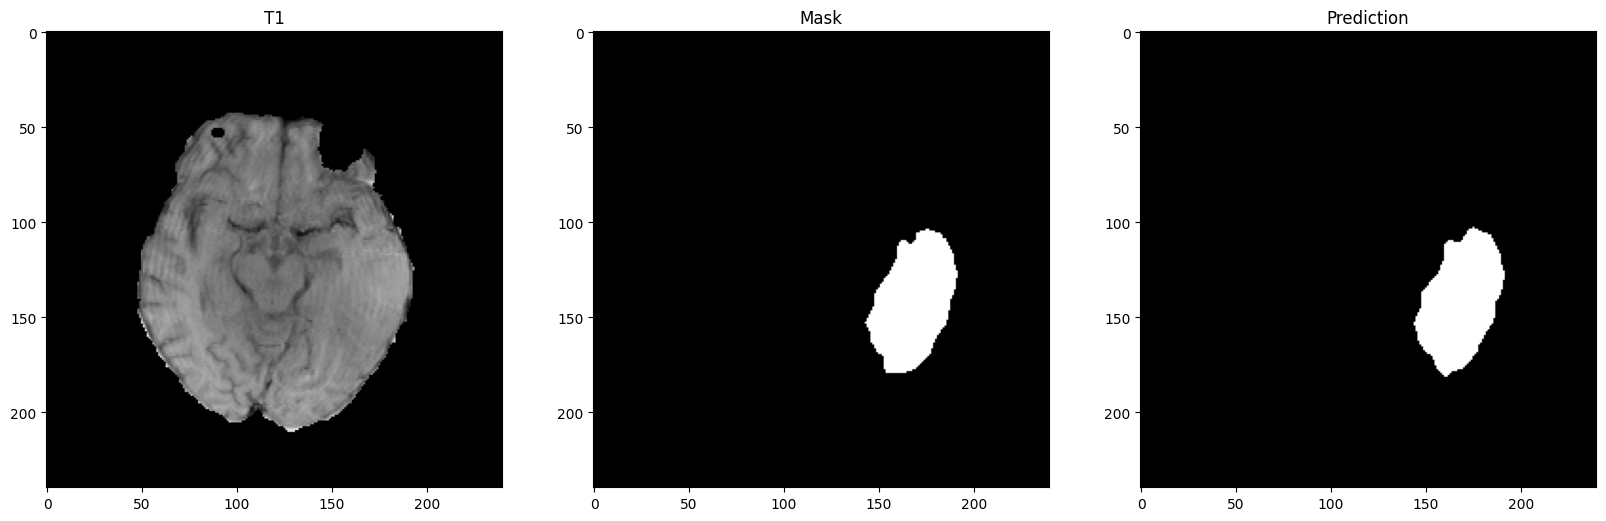

In [ ]:
# Calcular el coeficiente de Dice
dice_coefficient_values = []
image_history = []

# Realizar predicciones en todo el conjunto de datos de prueba
predictions = model.predict(validation_dataset)

# Calcular el coeficiente de Dice para cada máscara y obtener el promedio
for batch_index, (sequences, true_mask) in enumerate(validation_dataset):
    # Iterar sobre las instancias dentro del lote
    for instance_index in range(sequences.shape[0]):
        prediction_index = batch_index * BATCH_SIZE + instance_index
        # Umbralizar la predicción para obtener una máscara binaria
        predicted_mask = (predictions[prediction_index] > 0.5).astype(np.uint8)

        # Obtener las secuencias y la máscara real correspondiente para la instancia actual
        instance_sequences = sequences[instance_index].numpy()
        instance_true_mask = true_mask[instance_index].numpy()

        # Calcular el coeficiente de Dice usando la función dice_coefficient_numpy
        dice = dice_coefficient_numpy(instance_true_mask, predicted_mask)
        dice_coefficient_values.append(dice)

        # Almacenar las imagenes
        image_history.append((instance_sequences, instance_true_mask, predicted_mask))

print(f'Predicted masks: {len(predictions)}\tDice Coefficient: {np.mean(dice_coefficient_values)}')

# Visualizar algunas predicciones
for i in range(min(3, len(image_history))):
    sequences, mask, prediction = image_history[i]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.imshow(sequences[:, :, 0], cmap='gray')
    ax1.set_title('T1')
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask')
    ax3.imshow(prediction, cmap='gray')
    ax3.set_title('Prediction')
    plt.show()

Como se puede observar en las figuras, el nuevo modelo de CNN es capaz de detectar mejores los bordes de las máscaras, y perfeccionando así el contorno de estas, obteniendo un coeficiente mucho mayor que el primer modelo entrenado.

## Comparativa del mejor modelo entrenado de cada CNN

A continaución se comparan los resultados de ambos modelos sobre las mismas secuencias MRI, así como su rendimiento.

### Comparación de los mejores modelos CNN 1 y CNN 2

Esta celda genera un gráfico comparativo del coeficiente de Dice en validación para los mejores modelos de las arquitecturas **CNN 1** y **CNN 2**.

Se muestran las curvas de rendimiento a lo largo de las épocas, lo que permite observar:

- Qué tan bien generaliza cada modelo.
- Cuál mantiene un mejor rendimiento en validación.
- La evolución del entrenamiento respecto al sobreajuste o estabilidad.


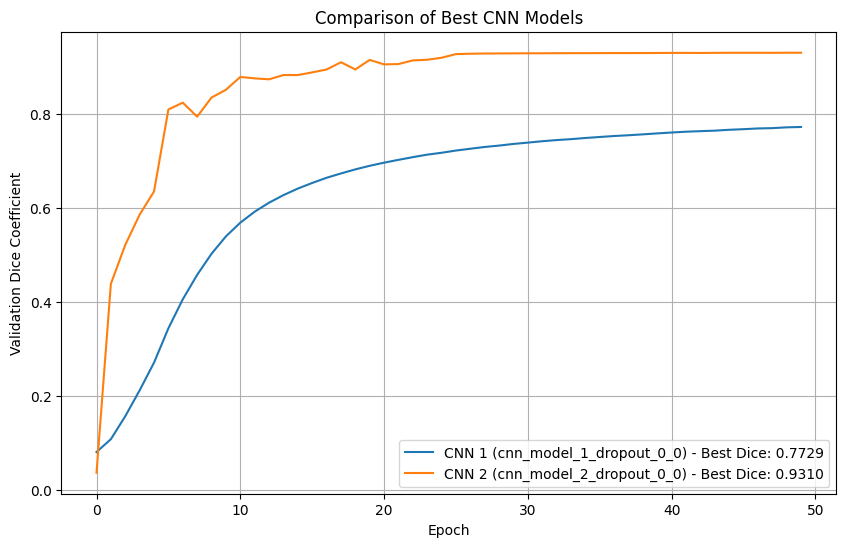

In [ ]:
import matplotlib.pyplot as plt


# Comparativa del mejor entrenamiento de cada modelo
plt.figure(figsize=(10, 6))
plt.plot(cnn_1["history"]["val_dice_coefficient"], label=f'CNN 1 ({cnn_1["model_name"]}) - Best Dice: {cnn_1["val_dice"]:.4f}')
plt.plot(cnn_2["history"]["val_dice_coefficient"], label=f'CNN 2 ({cnn_2["model_name"]}) - Best Dice: {cnn_2["val_dice"]:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Validation Dice Coefficient')
plt.title('Comparison of Best CNN Models')
plt.legend()
plt.grid(True)
plt.show()


Tal como se muestra, los resultados obtenidos por el segundo modelo son mucho mayores, aunque el primero ha conseguido un entrenamiento completamente progresivo.

### Comparación de épocas iniciales

Este gráfico compara el rendimiento en validación durante las **primeras 25 épocas** de entrenamiento de los mejores modelos de las arquitecturas **CNN 1** y **CNN 2**.


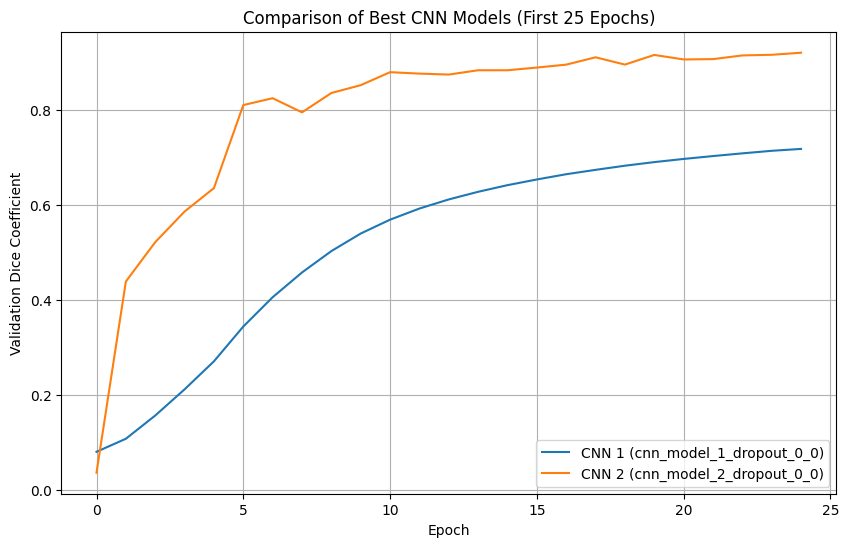

In [ ]:
import matplotlib.pyplot as plt

# Comparativa de las primeras etapas
plt.figure(figsize=(10, 6))
plt.plot(cnn_1["history"]["val_dice_coefficient"][:25], label=f'CNN 1 ({cnn_1["model_name"]})')
plt.plot(cnn_2["history"]["val_dice_coefficient"][:25], label=f'CNN 2 ({cnn_2["model_name"]})')
plt.xlabel('Epoch')
plt.ylabel('Validation Dice Coefficient')
plt.title('Comparison of Best CNN Models (First 25 Epochs)')
plt.legend()
plt.grid(True)
plt.show()


Centrándonos en las primeras etapas, se puede apreciar como el segundo modelo es capaz de llegar rápidamente al baseline de 0.6, mientras que al primero le cuesta algo más. Por otra parte, se puede observar como el segundo modelo en las primeras etapas le cuesta estabilizarse, probablemente porque el valor de learning rate es demasiado elevado.

### Comparación de épocas finales

Este gráfico muestra el rendimiento en validación de los mejores modelos **CNN 1** y **CNN 2** durante las **últimas 25 épocas** de entrenamiento.


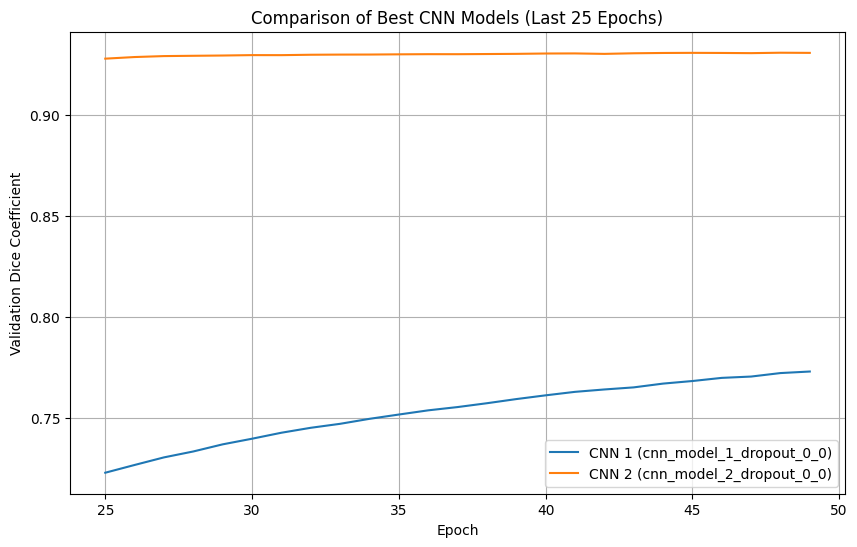

In [ ]:
import matplotlib.pyplot as plt

# Comparativa de las últimas etapas
plt.figure(figsize=(10, 6))
plt.plot(cnn_1["history"]["val_dice_coefficient"][25:], label=f'CNN 1 ({cnn_1["model_name"]})')
plt.plot(cnn_2["history"]["val_dice_coefficient"][25:], label=f'CNN 2 ({cnn_2["model_name"]})')
plt.xlabel('Epoch')
plt.ylabel('Validation Dice Coefficient')
plt.title('Comparison of Best CNN Models (Last 25 Epochs)')
plt.legend()
plt.grid(True)
plt.show()


Con este gráfico se puede observar como en las últimas entapas, mientras el primer modelo sigue mejorando, el segundo ya ha conseguido estabilizarse y se encarga de perfeccionar los contornos de las máscaras para acercarse más a un valor ideal de dice.

Seguidamente, se ha realizado una comparativa de las máscaras, tanto originales como predichas, directamente sobre las MRI.

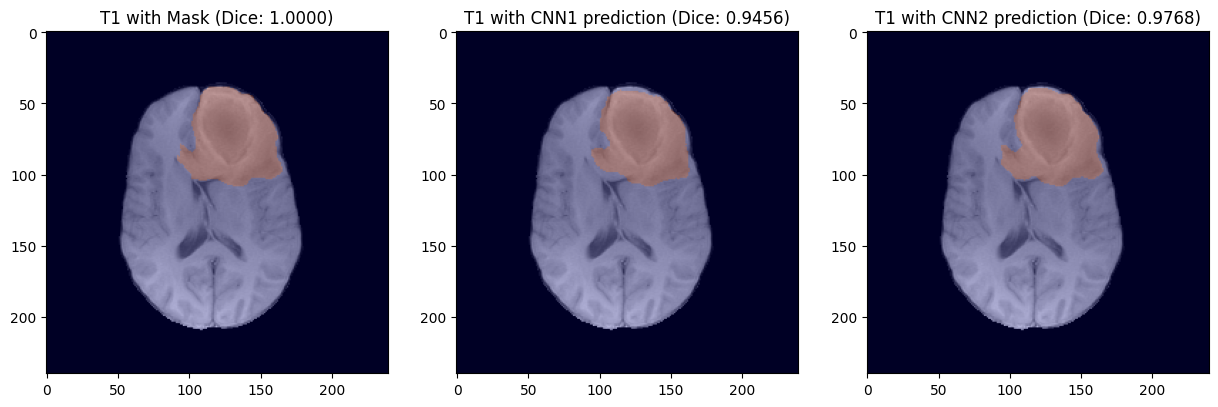

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Obtener la primera imagen y máscara del dataset
first_image, first_mask = next(iter(validation_dataset))
first_image = first_image.numpy()[0]
first_mask = first_mask.numpy()[0].squeeze()


# Predecir máscara con cnn_1
cnn1_prediction = cnn_1['model'].predict(np.expand_dims(first_image, axis=0), verbose=0)
cnn1_prediction = (cnn1_prediction[0] > 0.5).astype(np.uint8).squeeze()
dice_cnn1 = dice_coefficient_numpy(first_mask, cnn1_prediction)


# Predecir máscara con cnn_2
cnn2_prediction = cnn_2['model'].predict(np.expand_dims(first_image, axis=0), verbose=0)
cnn2_prediction = (cnn2_prediction[0] > 0.5).astype(np.uint8).squeeze()
dice_cnn2 = dice_coefficient_numpy(first_mask, cnn2_prediction)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Imagen 1: T1 con máscara original
axes[0].imshow(first_image[:, :, 0], cmap='gray')
axes[0].imshow(first_mask, alpha=0.3, cmap='jet')
axes[0].set_title(f'T1 with Mask (Dice: {dice_coefficient_numpy(first_mask, first_mask):.4f})')


# Imagen 2: T1 con predicción cnn1
axes[1].imshow(first_image[:, :, 0], cmap='gray')
axes[1].imshow(cnn1_prediction, alpha=0.3, cmap='jet')
axes[1].set_title(f'T1 with CNN1 prediction (Dice: {dice_cnn1:.4f})')


# Imagen 3: T1 con predicción cnn2
axes[2].imshow(first_image[:, :, 0], cmap='gray')
axes[2].imshow(cnn2_prediction, alpha=0.3, cmap='jet')
axes[2].set_title(f'T1 with CNN2 prediction (Dice: {dice_cnn2:.4f})')

plt.show()


Como se puede observar, el primer modelo deja alguna zona de la parte superior sin identificar, además de no definir adecuadamente la sección de la máscara que se encuentra en la extensión de la zona izquierda del tumor. Por otra parte, el segundo modelo ha logrado identificar correctamente tanto el área superior como la forma der extensión de la zona izquierda, mostrando un mayor rendimiento.

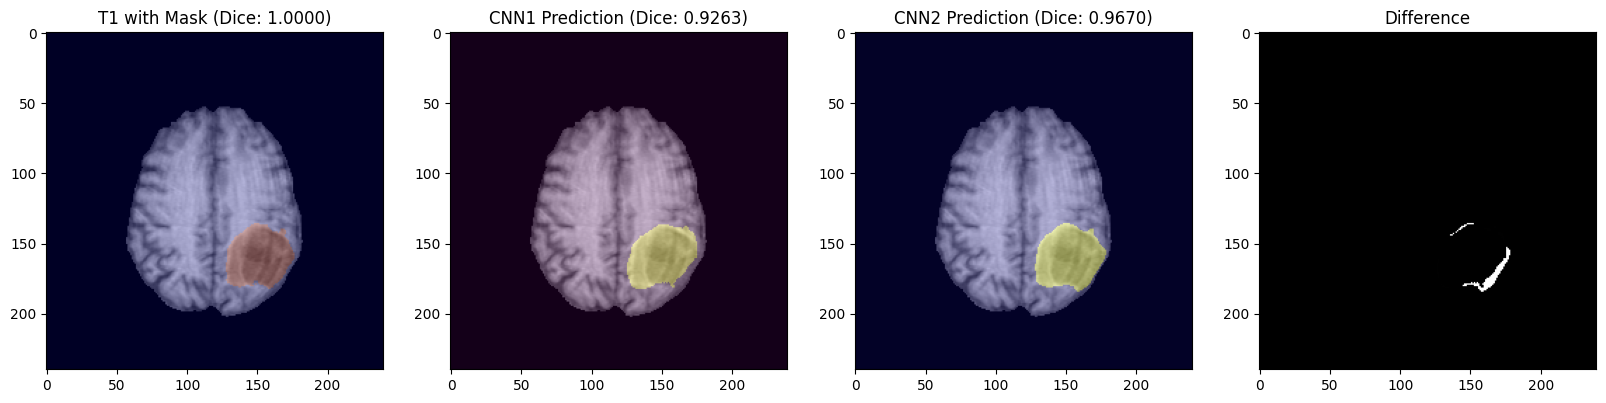

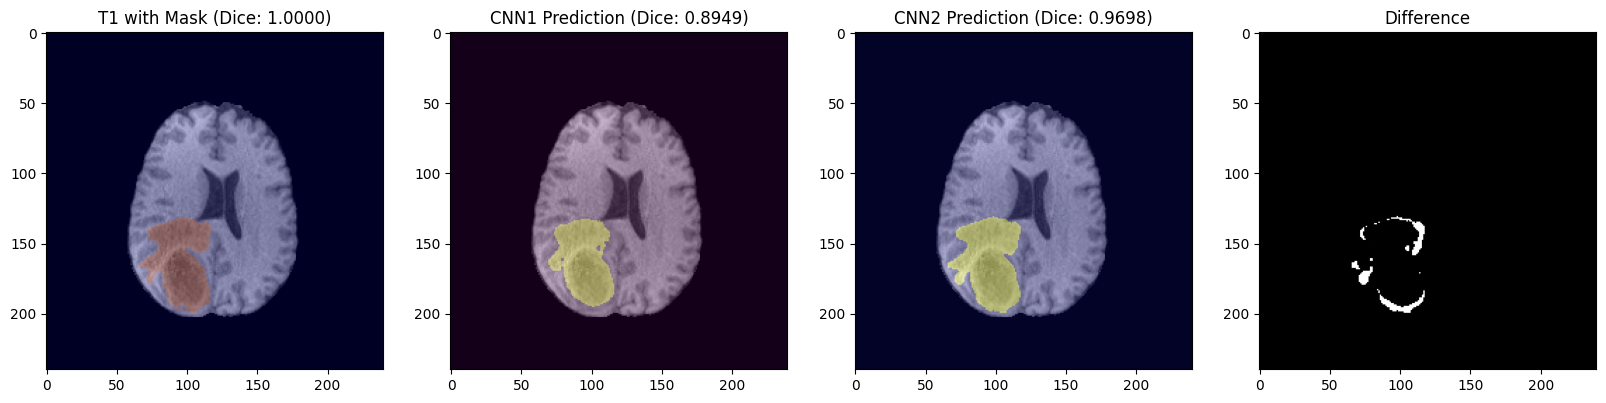

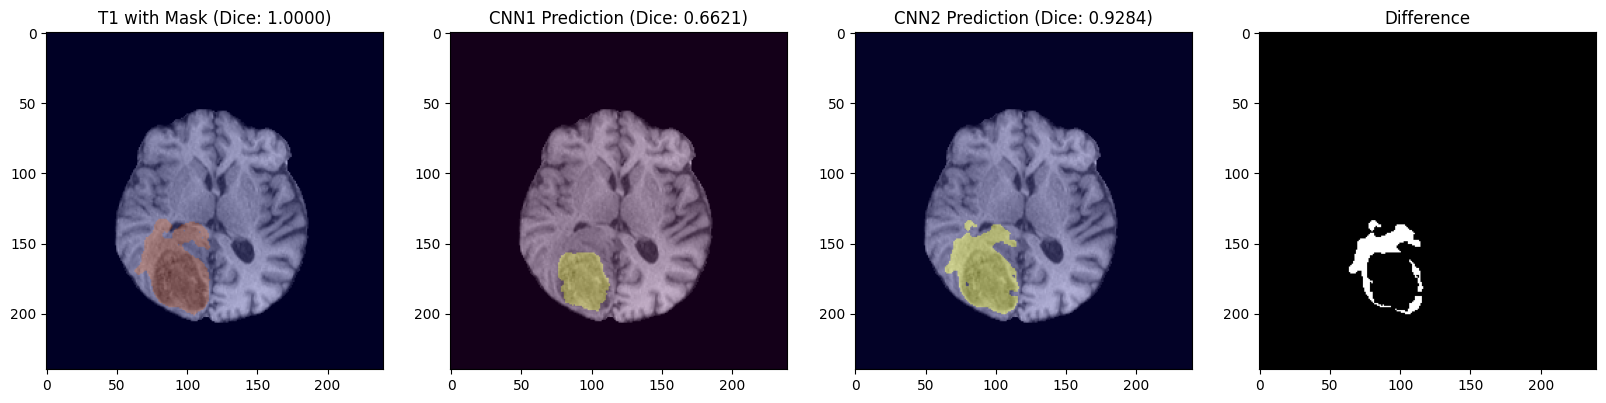

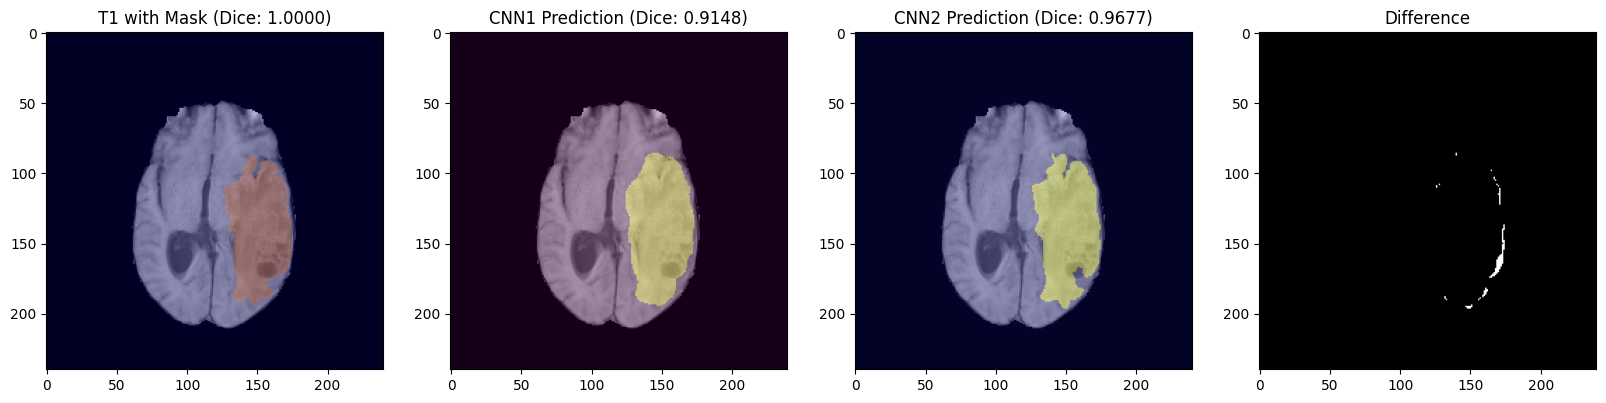

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

iterator = iter(validation_dataset)

# Salta la primera imagen, que ya se ha mostrado anteriormente
_ = next(iterator)

for i in range(0,4):
    image, mask = next(iterator)
    image = image.numpy()[0]
    mask = mask.numpy()[0].squeeze()

    # Predecir con cnn_1
    cnn1_prediction = cnn_1['model'].predict(np.expand_dims(image, axis=0), verbose=0)
    cnn1_prediction = (cnn1_prediction[0] > 0.5).astype(np.uint8).squeeze()
    dice_cnn1 = dice_coefficient_numpy(mask, cnn1_prediction)

    # Predecir con cnn_2
    cnn2_prediction = cnn_2['model'].predict(np.expand_dims(image, axis=0), verbose=0)
    cnn2_prediction = (cnn2_prediction[0] > 0.5).astype(np.uint8).squeeze()
    dice_cnn2 = dice_coefficient_numpy(mask, cnn2_prediction)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Imagen T1 original
    axes[0].imshow(image[:, :, 0], cmap='gray')
    axes[0].imshow(mask, alpha=0.3, cmap='jet')
    axes[0].set_title(f'T1 with Mask (Dice: {dice_coefficient_numpy(mask, mask):.4f})')

    # Predicción CNN1
    axes[1].imshow(image[:, :, 0], cmap='gray')
    axes[1].imshow(cnn1_prediction, alpha=0.3, cmap='viridis')
    axes[1].set_title(f'CNN1 Prediction (Dice: {dice_cnn1:.4f})')

    # Predicción CNN2
    axes[2].imshow(image[:, :, 0], cmap='gray')
    axes[2].imshow(cnn2_prediction, alpha=0.3, cmap='plasma')
    axes[2].set_title(f'CNN2 Prediction (Dice: {dice_cnn2:.4f})')

    # Diferencia
    axes[3].imshow(np.abs(cnn1_prediction-cnn2_prediction), cmap='gray')
    axes[3].set_title("Difference")

    plt.show()


Utilizando varias imágenes y comparando las diferencias en las predicciones, se puede observar más claramente como el segundo modelo se encarga de perfeccionar los bordes de las regiones tumorales para una segmentación más precisa, lo cual es especialmente observable en la segunda y tercera instancia mostrada.